In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, kendalltau
from itertools import combinations
from functools import reduce
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde
from scipy.integrate import simpson

### Preprocess steps

In [ ]:
ground_truth_df = pd.read_csv("AirQuality/Dataset/Ground_Truth_2023_Final.csv")
ground_truth_df.columns

Index(['city', 'state', 'YearMonth', 'AT', 'BP', 'PM2.5', 'RF', 'VWS', 'WD',
       'WS', 'latitude', 'longitude'],
      dtype='object')

In [55]:
gemma_9b_df = pd.read_csv("AirQuality/RQ1/Dataset/Predictions/gemma2_9b_it_2023_predictions.csv")
gemma_27b_df = pd.read_csv("AirQuality/RQ1/Dataset/Predictions/gemma2_27b_it_2023_predictions.csv")
llama_8b_df = pd.read_csv("AirQuality/RQ1/Dataset/Predictions/llama3_8b_it_2023_predictions.csv")
llama_70b_df = pd.read_csv("AirQuality/RQ1/Dataset/Predictions/llama3_70b_it_2023_predictions.csv")
llama1_70b_df = pd.read_csv("AirQuality/RQ1/Dataset/Predictions/llama3_1_70b_it_2023_predictions.csv")
qwen_32b_df = pd.read_csv("AirQuality/RQ1/Dataset/Predictions/qwen3_32b_2023_predictions.csv")
print(gemma_9b_df.columns)
print(gemma_27b_df.columns)
print(llama_8b_df.columns)
print(llama_70b_df.columns)
print(llama1_70b_df.columns)

Index(['city', 'state', 'year', 'month', 'model', 'pm2.5'], dtype='object')
Index(['city', 'state', 'year', 'month', 'model', 'pm2.5'], dtype='object')
Index(['city', 'state', 'year', 'month', 'model', 'pm2.5'], dtype='object')
Index(['city', 'state', 'year', 'month', 'model', 'pm2.5'], dtype='object')
Index(['city', 'state', 'year', 'month', 'model', 'pm2.5'], dtype='object')


In [7]:
gemma_9b_df_nan = pd.read_csv("AirQuality/RQ1/Dataset/gemma2_9b_it_2023_NaN.csv")
gemma_27b_df_nan = pd.read_csv("AirQuality/RQ1/Dataset/gemma2_27b_it_2023_NaN.csv")
llama_8b_df_nan = pd.read_csv("AirQuality/RQ1/Dataset/llama3_8b_it_2023_NaN.csv")
llama_70b_df_nan = pd.read_csv("AirQuality/RQ1/Dataset/llama3_70b_it_2023_NaN.csv")
llama1_70b_df_nan = pd.read_csv("AirQuality/RQ1/Dataset/llama3_1_70b_it_2023_NaN.csv")

In [8]:
model_dfs_nan = {
    "gemma-2-9b-it": gemma_9b_df_nan,
    "gemma-2-27b-it": gemma_27b_df_nan,
    "llama-3.1-8b-Instruct": llama_8b_df_nan,
    "llama-3.1-70b-Instruct": llama1_70b_df_nan,
    "llama-3.3-70b-Instruct": llama_70b_df_nan
}

In [4]:
gemma_9b_df.head()

,city,state,year,month,model,pm2.5
0,Agartala,Tripura,2023,January,google/gemma-2-9b-it,38.7
1,Agartala,Tripura,2023,February,google/gemma-2-9b-it,35.2
2,Agartala,Tripura,2023,March,google/gemma-2-9b-it,35.2
3,Agartala,Tripura,2023,April,google/gemma-2-9b-it,38.7
4,Agartala,Tripura,2023,May,google/gemma-2-9b-it,38.7


In [5]:
ground_truth_df['YearMonth'] = pd.to_datetime(ground_truth_df['YearMonth'])
ground_truth_df['year'] = ground_truth_df['YearMonth'].dt.year
ground_truth_df['month'] = ground_truth_df['YearMonth'].dt.strftime('%B')

ground_truth_df = ground_truth_df.rename(columns={'PM2.5': 'ground_truth_pm25'})

ground_truth_df = ground_truth_df[['city', 'state', 'year', 'month', 'YearMonth', 'ground_truth_pm25']]

In [5]:
ground_truth_df.head()

,city,state,year,month,YearMonth,ground_truth_pm25
0,Agartala,Tripura,2023,January,2023-01-01,196.040103
1,Agartala,Tripura,2023,February,2023-02-01,170.874875
2,Agartala,Tripura,2023,March,2023-03-01,119.490881
3,Agartala,Tripura,2023,April,2023-04-01,94.205356
4,Agartala,Tripura,2023,May,2023-05-01,63.553585


### Do LLMs predict within the valid PM2.5 range (0–500 μg/m³)?

In [8]:
def check_valid_pm25_range_table_ignore_nan(dfs_with_names):
    results = []

    for df, model_name in dfs_with_names:
        df = df.copy()
        df['pm2.5'] = pd.to_numeric(df['pm2.5'], errors='coerce')

        df = df.dropna(subset=['pm2.5'])
        total = len(df)

        count_below_0 = (df['pm2.5'] < 0).sum()
        count_above_500 = (df['pm2.5'] > 500).sum()
        count_valid = df['pm2.5'].between(0, 500).sum()

        percent_valid = (count_valid / total) * 100
        percent_below_0 = (count_below_0 / total) * 100
        percent_above_500 = (count_above_500 / total) * 100

        valid_check = "Match" if (
            (percent_valid == 100) or (count_below_0 > 0 or count_above_500 > 0)
        ) else "Mismatch"

        results.append({
            "Model": model_name,
            "% (PM2.5 in 0-500)": f"{percent_valid:.2f}%",
            "% (PM2.5 < 0)": f"{percent_below_0:.2f}%",
            "% (PM2.5 > 500)": f"{percent_above_500:.2f}%",
        })

    result_df = pd.DataFrame(results)
    print(result_df)

check_valid_pm25_range_table_ignore_nan([
    (gemma_9b_df, "Gemma 2 - 9B"),
    (gemma_27b_df, "Gemma 2 - 27B"),
    (llama_8b_df, "LLaMA 3.1 - 8B"),
    # (llama3_70b_df , "LLaMA 3.1 - 70B"),
    (llama_70b_df, "LLaMA 3.3 - 70B"),
])

             Model % (PM2.5 in 0-500) % (PM2.5 < 0) % (PM2.5 > 500)
0     Gemma 2 - 9B            100.00%         0.00%           0.00%
1    Gemma 2 - 27B            100.00%         0.00%           0.00%
2   LLaMA 3.1 - 8B            100.00%         0.00%           0.00%
3  LLaMA 3.3 - 70B            100.00%         0.00%           0.00%


### Are predictions correlated with ground-truth CPCB data?

1. **Pearson Correlation Coefficient**

Measures linear correlation between predicted and actual values:

$$
\text{Pearson}(y, \hat{y}) = \frac{\sum_{i=1}^{n} (y_i - \bar{y})(\hat{y}_i - \bar{\hat{y}})}{\sqrt{\sum_{i=1}^{n} (y_i - \bar{y})^2} \sqrt{\sum_{i=1}^{n} (\hat{y}_i - \bar{\hat{y}})^2}}
$$

2. **Spearman Rank Correlation**

Measures monotonic relationship between the rankings of predicted and actual values:

$$
\text{Spearman}(y, \hat{y}) = \text{Pearson}(\text{rank}(y), \text{rank}(\hat{y}))
$$

Spearman's $\rho$ as the Pearson correlation of the ranks:

$$
\rho(x, y) = \frac{\mathrm{Cov}(R(x), R(y))}{\sigma_{R(x)} \, \sigma_{R(y)}}
$$

3. **Mean Absolute Error (MAE)**

Average of the absolute differences between actual and predicted values:

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
$$

4. **Root Mean Squared Error (RMSE)**

Square root of the average squared differences between actual and predicted values:

$$
\text{RMSE} = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 }
$$

In [7]:
# def evaluate_model_against_ground_truth(model_df, model_name):
#     # Merge with ground truth

#     model_df = model_df.copy()
#     ground_df = ground_truth_df.copy()

#     for df in [model_df, ground_df]:
#         df['city_lower'] = df['city'].str.strip().str.lower()
#         df['state_lower'] = df['state'].str.strip().str.lower()
#         df['month_lower'] = df['month'].str.strip().str.lower()
#         df['year'] = df['year'].astype(int)

#     merged_df = pd.merge(
#         model_df,
#         ground_df,
#         left_on=['city_lower', 'state_lower', 'year', 'month_lower'],
#         right_on=['city_lower', 'state_lower', 'year', 'month_lower'],
#         how='inner'
#     )

#     y_true = merged_df['ground_truth_pm25']
#     y_pred = merged_df['pm2.5']

#     valid = (~y_true.isna()) & (~y_pred.isna())
#     y_true = y_true[valid]
#     y_pred = y_pred[valid]

#     # Compute metrics
#     pearson_corr, _ = pearsonr(y_true, y_pred)
#     spearman_corr, _ = spearmanr(y_true, y_pred)
#     mae = mean_absolute_error(y_true, y_pred)
#     rmse = np.sqrt(mean_squared_error(y_true, y_pred))

#     # Under and Over prediction
#     total = len(y_true)
#     under = (y_pred < y_true).sum()
#     over = (y_pred > y_true).sum()
#     equal = (y_pred == y_true).sum()  # Optional

#     percent_under = 100 * under / total
#     percent_over = 100 * over / total
#     percent_equal = 100 * equal / total  # Optional

#     print(f"\n{model_name} Evaluation:")
#     print(f"  Pearson Correlation : {pearson_corr:.4f}")
#     print(f"  Spearman Correlation: {spearman_corr:.4f}")
#     print(f"  MAE (μg/m³)         : {mae:.4f}")
#     print(f"  RMSE (μg/m³)        : {rmse:.4f}")
#     print(f"  Under-predictions   : {percent_under:.4f}%")
#     print(f"  Over-predictions    : {percent_over:.4f}%")
#     if percent_equal > 0:
#         print(f"  Exact matches       : {percent_equal:.4f}%")

#     return {
#         'model': model_name,
#         'pearson': pearson_corr,
#         'spearman': spearman_corr,
#         'mae': mae,
#         'rmse': rmse,
#         'under_percent': percent_under,
#         'over_percent': percent_over,
#         'equal_percent': percent_equal  # Optional
#     }

In [9]:
def evaluate_model_against_ground_truth(model_df, model_name):
    # Merge with ground truth
    model_df = model_df.copy()
    ground_df = ground_truth_df.copy()

    for df in [model_df, ground_df]:
        df['city_lower'] = df['city'].str.strip().str.lower()
        df['state_lower'] = df['state'].str.strip().str.lower()
        df['month_lower'] = df['month'].str.strip().str.lower()
        df['year'] = df['year'].astype(int)

    merged_df = pd.merge(
        model_df,
        ground_df,
        left_on=['city_lower', 'state_lower', 'year', 'month_lower'],
        right_on=['city_lower', 'state_lower', 'year', 'month_lower'],
        how='inner'
    )

    y_true = merged_df['ground_truth_pm25']
    y_pred = merged_df['pm2.5']

    valid = (~y_true.isna()) & (~y_pred.isna())
    y_true = y_true[valid]
    y_pred = y_pred[valid]

    # Compute metrics
    pearson_corr, _ = pearsonr(y_true, y_pred)
    spearman_corr, _ = spearmanr(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Under and Over prediction
    under_mask = y_pred < y_true
    over_mask = y_pred > y_true
    equal_mask = y_pred == y_true

    total = len(y_true)
    percent_under = 100 * under_mask.sum() / total
    percent_over = 100 * over_mask.sum() / total
    percent_equal = 100 * equal_mask.sum() / total  # Optional

    # Compute MAE for under- and over-predictions
    mae_under = mean_absolute_error(y_true[under_mask], y_pred[under_mask]) if under_mask.any() else np.nan
    mae_over = mean_absolute_error(y_true[over_mask], y_pred[over_mask]) if over_mask.any() else np.nan

    print(f"\n{model_name} Evaluation:")
    print(f"  Pearson Correlation : {pearson_corr:.4f}")
    print(f"  Spearman Correlation: {spearman_corr:.4f}")
    print(f"  MAE (μg/m³)         : {mae:.4f}")
    print(f"  RMSE (μg/m³)        : {rmse:.4f}")
    print(f"  Under-predictions   : {percent_under:.4f}%")
    print(f"  Over-predictions    : {percent_over:.4f}%")
    if percent_equal > 0:
        print(f"  Exact matches       : {percent_equal:.4f}%")
    print(f"  MAE (Under-pred)    : {mae_under:.4f}")
    print(f"  MAE (Over-pred)     : {mae_over:.4f}")

    return {
        'model': model_name,
        'pearson': pearson_corr,
        'spearman': spearman_corr,
        'mae': mae,
        'rmse': rmse,
        'under_percent': percent_under,
        'over_percent': percent_over,
        'equal_percent': percent_equal,
        'mae_under': mae_under,
        'mae_over': mae_over
    }

In [10]:
results = []
results.append(evaluate_model_against_ground_truth(gemma_9b_df, "Gemma 2 - 9B"))
results.append(evaluate_model_against_ground_truth(gemma_27b_df, "Gemma 2 - 27B"))
results.append(evaluate_model_against_ground_truth(llama_8b_df, "LLaMA 3.1 - 8B"))
results.append(evaluate_model_against_ground_truth(llama1_70b_df, "LLaMA 3.1 - 70B"))
results.append(evaluate_model_against_ground_truth(llama_70b_df, "LLaMA 3.3 - 70B"))


Gemma 2 - 9B Evaluation:
  Pearson Correlation : 0.2454
  Spearman Correlation: 0.3162
  MAE (μg/m³)         : 27.3261
  RMSE (μg/m³)        : 39.7489
  Under-predictions   : 40.3004%
  Over-predictions    : 59.6996%
  MAE (Under-pred)    : 32.3280
  MAE (Over-pred)     : 23.9496

Gemma 2 - 27B Evaluation:
  Pearson Correlation : 0.5781
  Spearman Correlation: 0.6327
  MAE (μg/m³)         : 34.7241
  RMSE (μg/m³)        : 41.7129
  Under-predictions   : 12.6451%
  Over-predictions    : 87.3549%
  MAE (Under-pred)    : 29.1247
  MAE (Over-pred)     : 35.5347

LLaMA 3.1 - 8B Evaluation:
  Pearson Correlation : 0.2485
  Spearman Correlation: 0.3111
  MAE (μg/m³)         : 37.6088
  RMSE (μg/m³)        : 51.6771
  Under-predictions   : 91.4807%
  Over-predictions    : 8.5193%
  MAE (Under-pred)    : 40.2366
  MAE (Over-pred)     : 9.3914

LLaMA 3.1 - 70B Evaluation:
  Pearson Correlation : 0.6091
  Spearman Correlation: 0.6172
  MAE (μg/m³)         : 32.6812
  RMSE (μg/m³)        : 45.254

In [8]:
results_df = pd.DataFrame(results)

results_df

,model,pearson,spearman,mae,rmse,under_percent,over_percent,equal_percent
0,Gemma 2 - 9B,0.245439,0.316159,27.326134,39.748886,40.300375,59.699625,0.0
1,Gemma 2 - 27B,0.578111,0.632667,34.724122,41.712921,12.645108,87.354892,0.0
2,LLaMA 3.1 - 8B,0.248513,0.311148,37.608788,51.677108,91.480730,8.519270,0.0
3,LLaMA 3.1 - 70B,0.609134,0.617235,32.681208,45.254553,24.827586,75.172414,0.0
4,LLaMA 3.3 - 70B,0.548590,0.579094,46.701547,57.482958,12.106136,87.893864,0.0


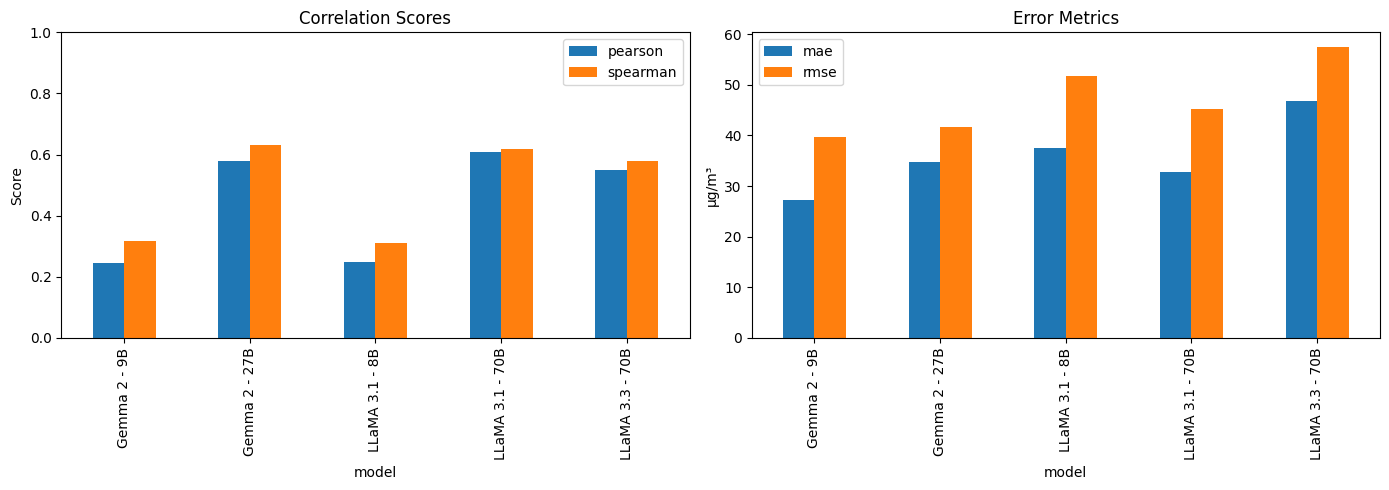

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

results_df.plot(x='model', y=['pearson', 'spearman'], kind='bar', ax=axes[0])
axes[0].set_title('Correlation Scores')
axes[0].set_ylabel('Score')
axes[0].set_ylim(0, 1)

results_df.plot(x='model', y=['mae', 'rmse'], kind='bar', ax=axes[1])
axes[1].set_title('Error Metrics')
axes[1].set_ylabel('μg/m³')

plt.tight_layout()
plt.show()

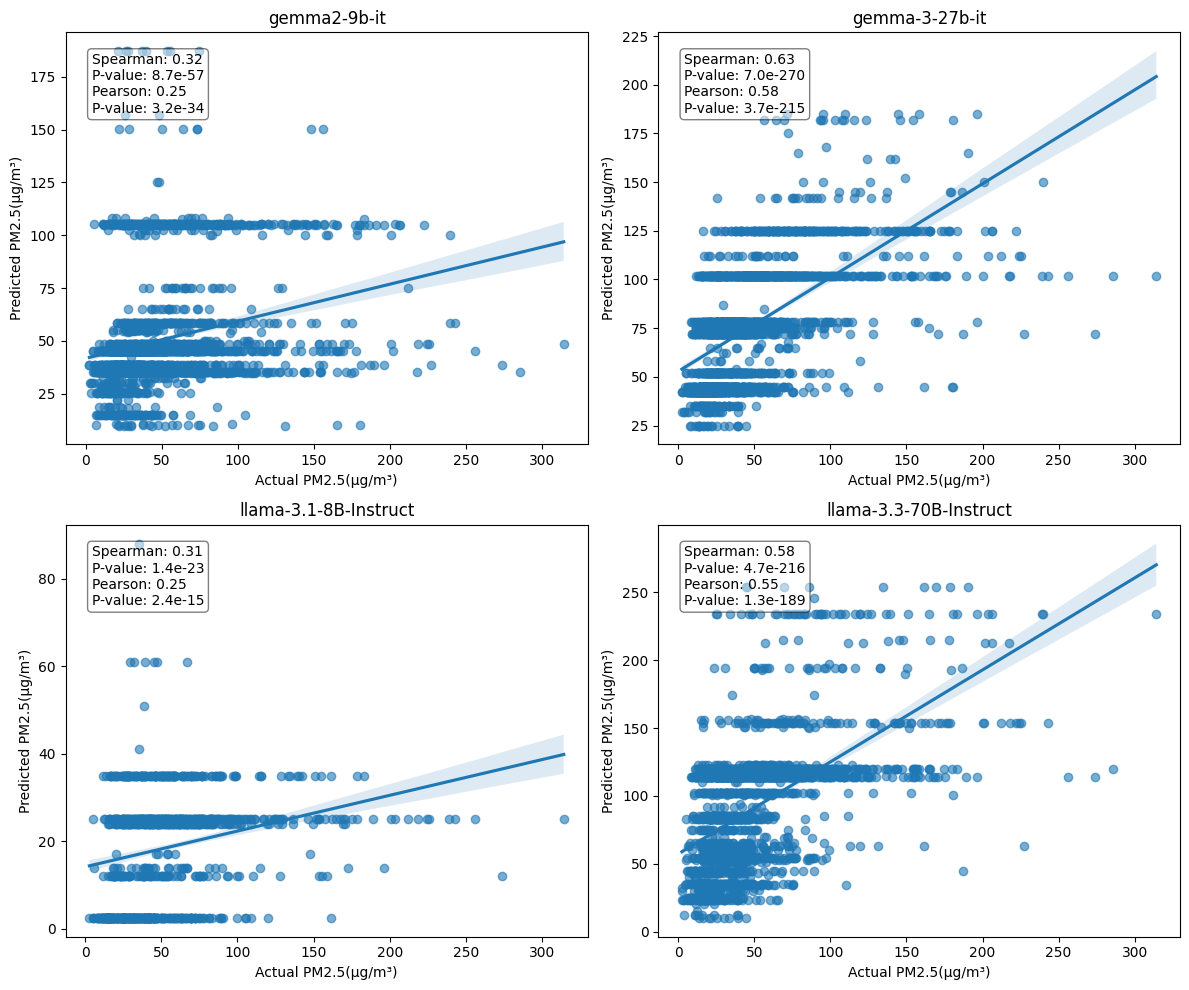

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

model_data = [
    (gemma_9b_df, "gemma2-9b-it"),
    (gemma_27b_df, "gemma-3-27b-it"),
    (llama_8b_df, "llama-3.1-8B-Instruct"),
    (llama_70b_df, "llama-3.3-70B-Instruct"),
]

for ax, (model_df, model_name) in zip(axes.flatten(), model_data):
    model_df = model_df.copy()
    ground_df = ground_truth_df.copy()

    for df in [model_df, ground_df]:
        df['city_lower'] = df['city'].str.strip().str.lower()
        df['state_lower'] = df['state'].str.strip().str.lower()
        df['month_lower'] = df['month'].str.strip().str.lower()
        df['year'] = df['year'].astype(int)

    merged_df = pd.merge(
        model_df,
        ground_df,
        left_on=['city_lower', 'state_lower', 'year', 'month_lower'],
        right_on=['city_lower', 'state_lower', 'year', 'month_lower'],
        how='inner'
    )

    y_true = merged_df['ground_truth_pm25']
    y_pred = merged_df['pm2.5']
    
    valid = (~y_true.isna()) & (~y_pred.isna())
    y_true = y_true[valid]
    y_pred = y_pred[valid]
    
    sns.regplot(x=y_true, y=y_pred, ax=ax, scatter_kws={'alpha': 0.6})
    
    # Correlation and p-values
    spearman_corr, spearman_p = spearmanr(y_true, y_pred)
    pearson_corr, pearson_p = pearsonr(y_true, y_pred)
    annotation = (
        f"Spearman: {spearman_corr:.2f}\n"
        f"P-value: {spearman_p:.1e}\n"
        f"Pearson: {pearson_corr:.2f}\n"
        f"P-value: {pearson_p:.1e}"
    )
    
    ax.text(0.05, 0.95, annotation, transform=ax.transAxes,
            fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))
    
    ax.set_title(model_name)
    ax.set_xlabel("Actual PM2.5(μg/m³)")
    ax.set_ylabel("Predicted PM2.5(μg/m³)")  # or "Predicted PM2.5"

plt.tight_layout()
plt.show()

### Can models capture national and city-level seasonal pollution trends?

#### National Level

In [9]:
gemma_9b_df_national = pd.read_csv("AirQuality/RQ1/Dataset/gemma2_9b_it_nation_level_2023.csv")
gemma_27b_df_national = pd.read_csv("AirQuality/RQ1/Dataset/gemma2_27b_it_nation_level_2023.csv")
llama_8b_df_national = pd.read_csv("AirQuality/RQ1/Dataset/llama3_8b_it_nation_level_2023.csv")
llama_70b_df_national = pd.read_csv("AirQuality/RQ1/Dataset/llama3_70b_it_nation_level_2023.csv")
# llama1_70b_df_national = pd.read_csv("AirQuality/RQ1/Dataset/llama3_1_70b_it_nation_level_2023.csv")

In [15]:
gemma_9b_df_national

,year,month,model,pm2.5
0,2023,January,google/gemma-2-9b-it,58.0
1,2023,February,google/gemma-2-9b-it,58.0
2,2023,March,google/gemma-2-9b-it,58.0
3,2023,April,google/gemma-2-9b-it,58.0
4,2023,May,google/gemma-2-9b-it,58.0
5,2023,June,google/gemma-2-9b-it,58.0
6,2023,July,google/gemma-2-9b-it,50.0
7,2023,August,google/gemma-2-9b-it,50.0
8,2023,September,google/gemma-2-9b-it,50.0
9,2023,October,google/gemma-2-9b-it,50.0


In [10]:
ground_truth_national_df = pd.read_csv("AirQuality/RQ1/Dataset/Monthly_GroudTruth.csv")
ground_truth_national_df

,month,PM2.5
0,January,94.284053
1,February,71.043501
2,March,52.124080
3,April,45.866062
4,May,40.110945
5,June,31.499145
6,July,25.429050
7,August,28.226779
8,September,27.779465
9,October,54.794726


In [11]:
# === Load Ground Truth ===
gt_df = pd.read_csv("AirQuality/RQ1/Dataset/Monthly_GroudTruth.csv")
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
gt_df['month'] = pd.Categorical(gt_df['month'], categories=month_order, ordered=True)
gt_df = gt_df.sort_values('month')

# === Partial Order Agreement Function ===
def partial_order_agreement(gt_values, pred_values):
    assert len(gt_values) == len(pred_values)
    total = 0
    correct = 0
    for i, j in combinations(range(len(gt_values)), 2):
        if gt_values[i] == gt_values[j]:
            continue  # skip ties in ground-truth
        gt_order = gt_values[i] > gt_values[j]
        pred_order = pred_values[i] > pred_values[j]
        if gt_order == pred_order:
            correct += 1
        total += 1
    return correct / total if total > 0 else None

# === Model Paths ===
model_paths = {
    "gemma-2-9b-it": "AirQuality/RQ1/Dataset/gemma2_9b_it_nation_level_2023.csv",
    "gemma-2-27b-it": "AirQuality/RQ1/Dataset/gemma2_27b_it_nation_level_2023.csv",
    "llama-3-8b-it": "AirQuality/RQ1/Dataset/llama3_8b_it_nation_level_2023.csv",
    "llama-3-70b-it": "AirQuality/RQ1/Dataset/llama3_70b_it_nation_level_2023.csv"
}

# === Compute Metrics ===
results = []

for model_name, path in model_paths.items():
    df = pd.read_csv(path)
    df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)
    df = df.sort_values('month')

    merged = pd.merge(gt_df, df, on='month', how='inner')
    merged = merged.dropna(subset=['PM2.5', 'pm2.5'])

    y_true = merged['PM2.5'].values
    y_pred = merged['pm2.5'].values

    mae = mean_absolute_error(y_true, y_pred)
    
    # Handle cases where Pearson or Spearman can't be computed due to constant input
    try:
        pearson_corr, _ = pearsonr(y_true, y_pred)
    except:
        pearson_corr = float('nan')
    
    try:
        spearman_corr, _ = spearmanr(y_true, y_pred)
    except:
        spearman_corr = float('nan')
    
    try:
        kendall_corr, _ = kendalltau(y_true, y_pred)
    except:
        kendall_corr = float('nan')
    
    po_score = partial_order_agreement(y_true, y_pred)

    results.append({
        'Model': model_name,
        'MAE': round(mae, 2),
        'Pearson': round(pearson_corr, 3) if pd.notnull(pearson_corr) else None,
        'Spearman': round(spearman_corr, 3) if pd.notnull(spearman_corr) else None,
        'KendallTauB': round(kendall_corr, 3) if pd.notnull(kendall_corr) else None,
        'PartialOrderAgreement': round(po_score, 3) if po_score is not None else None
    })

# === Display ===
results_df = pd.DataFrame(results)
results_df

/tmp/ipykernel_1282337/146798885.py:49: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(y_true, y_pred)
/tmp/ipykernel_1282337/146798885.py:54: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(y_true, y_pred)


,Model,MAE,Pearson,Spearman,KendallTauB,PartialOrderAgreement
0,gemma-2-9b-it,21.33,0.097,0.193,0.164,0.530
1,gemma-2-27b-it,23.54,0.866,0.781,0.647,0.758
2,llama-3-8b-it,20.21,NaN,NaN,NaN,0.000
3,llama-3-70b-it,38.24,0.783,0.813,0.668,0.742


In [18]:
month_order = ["January", "February", "March", "April", "May", "June",
               "July", "August", "September", "October", "November", "December"]

def plot_monthly_comparison(model_df, model_name, ground_truth_df):
    model_df['month'] = pd.Categorical(model_df['month'], categories=month_order, ordered=True)
    model_df = model_df.sort_values('month')
    ground_truth_df['month'] = pd.Categorical(ground_truth_df['month'], categories=month_order, ordered=True)
    ground_truth_df = ground_truth_df.sort_values('month')

    model_df = model_df.rename(columns={'pm2.5': 'Predicted_PM2.5'})
    ground_truth_df = ground_truth_df.rename(columns={'PM2.5': 'GroundTruth_PM2.5'})

    merged = pd.merge(model_df[['month', 'Predicted_PM2.5']], 
                      ground_truth_df[['month', 'GroundTruth_PM2.5']], 
                      on='month', how='inner')
    
    x = range(len(merged))
    width = 0.4

    plt.figure(figsize=(12, 6))
    plt.bar([i - width/2 for i in x], merged['Predicted_PM2.5'], width=width, label='Predicted')
    plt.bar([i + width/2 for i in x], merged['GroundTruth_PM2.5'], width=width, label='Ground Truth')

    plt.xticks(x, merged['month'], rotation=45)
    plt.ylabel("PM2.5 (μg/m³)")
    plt.title(f"Monthly PM2.5 Comparison - {model_name}")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

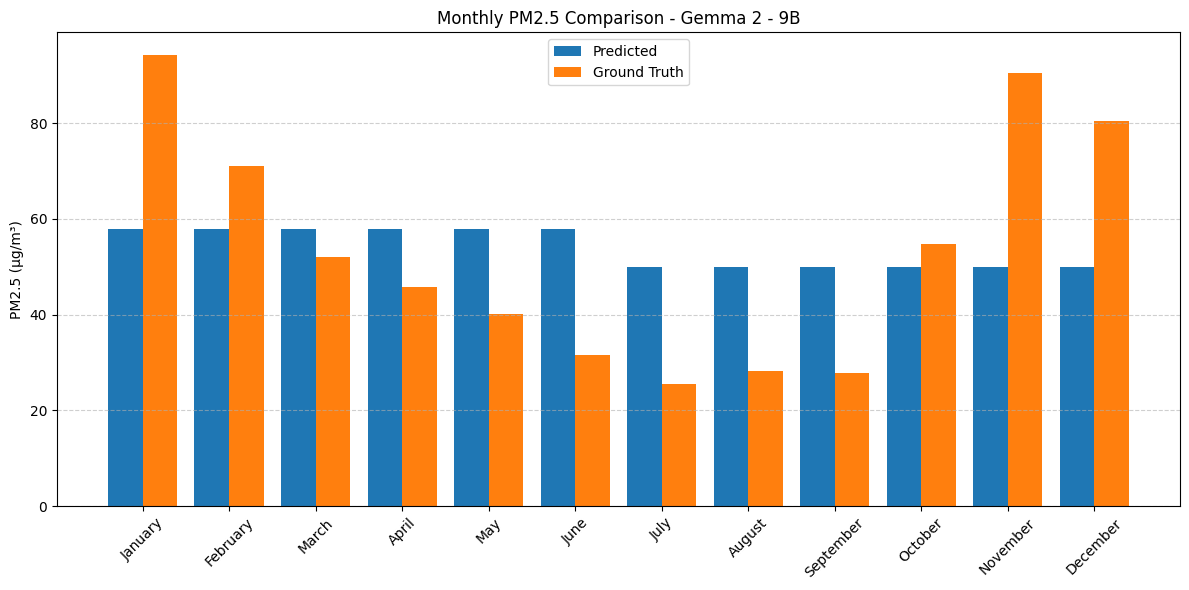

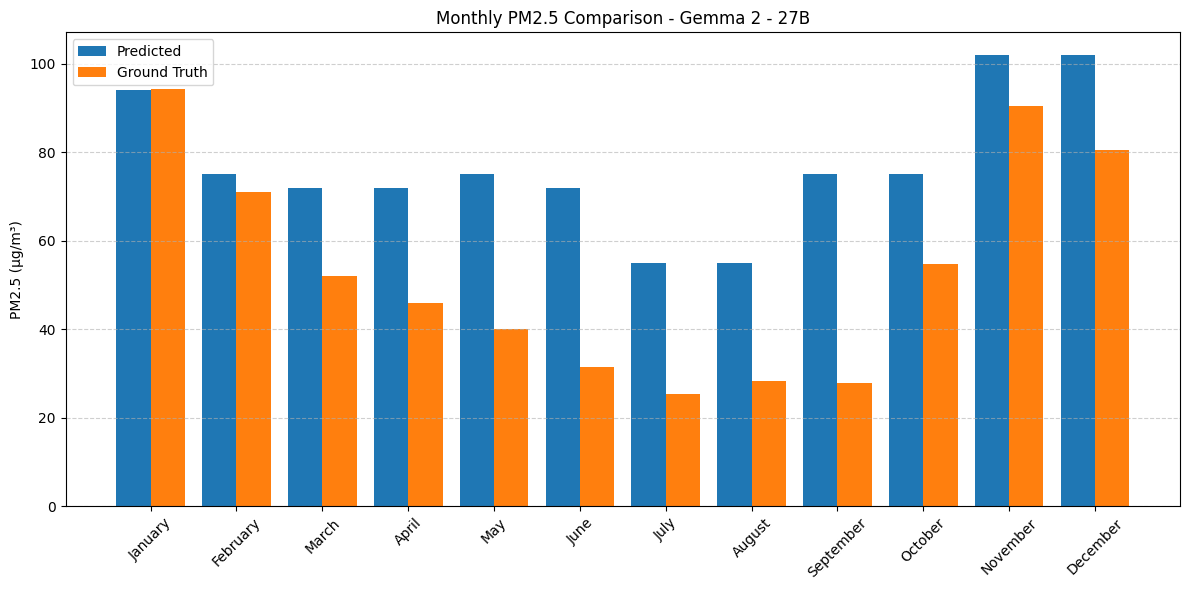

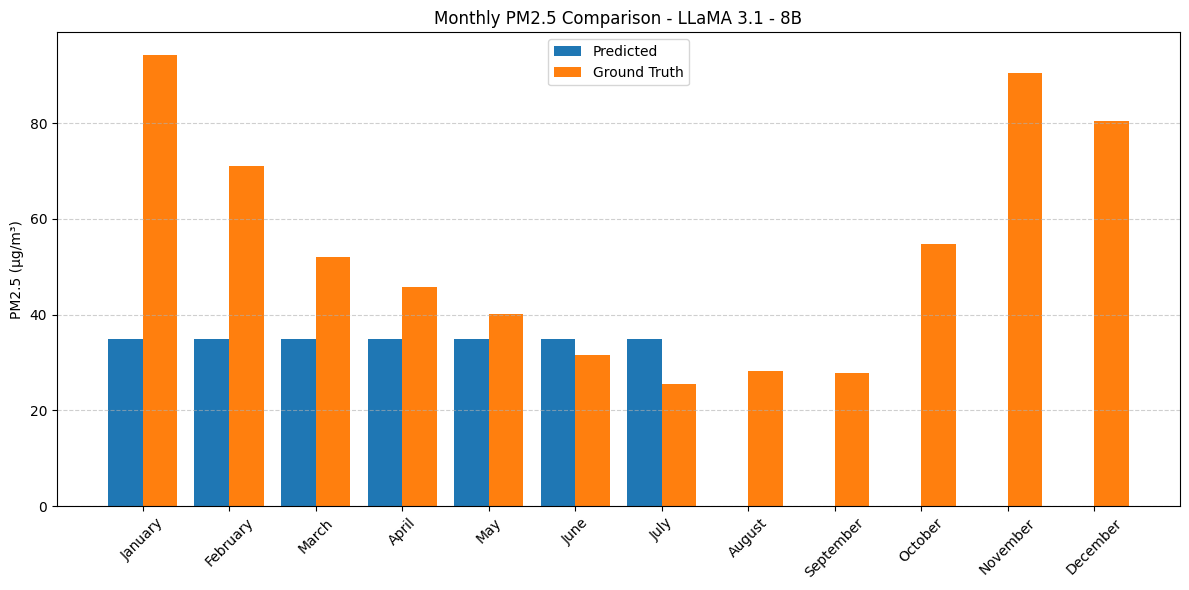

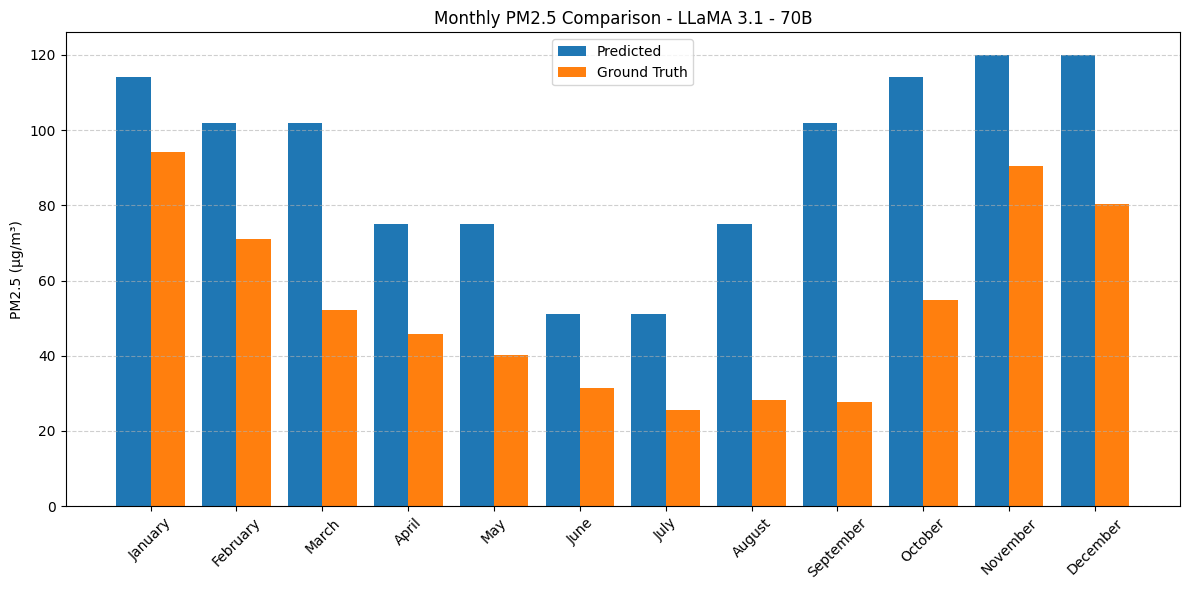

In [19]:
plot_monthly_comparison(gemma_9b_df_national, "Gemma 2 - 9B", ground_truth_national_df)
plot_monthly_comparison(gemma_27b_df_national, "Gemma 2 - 27B", ground_truth_national_df)
plot_monthly_comparison(llama_8b_df_national, "LLaMA 3.1 - 8B", ground_truth_national_df)
plot_monthly_comparison(llama_70b_df_national, "LLaMA 3.1 - 70B", ground_truth_national_df)

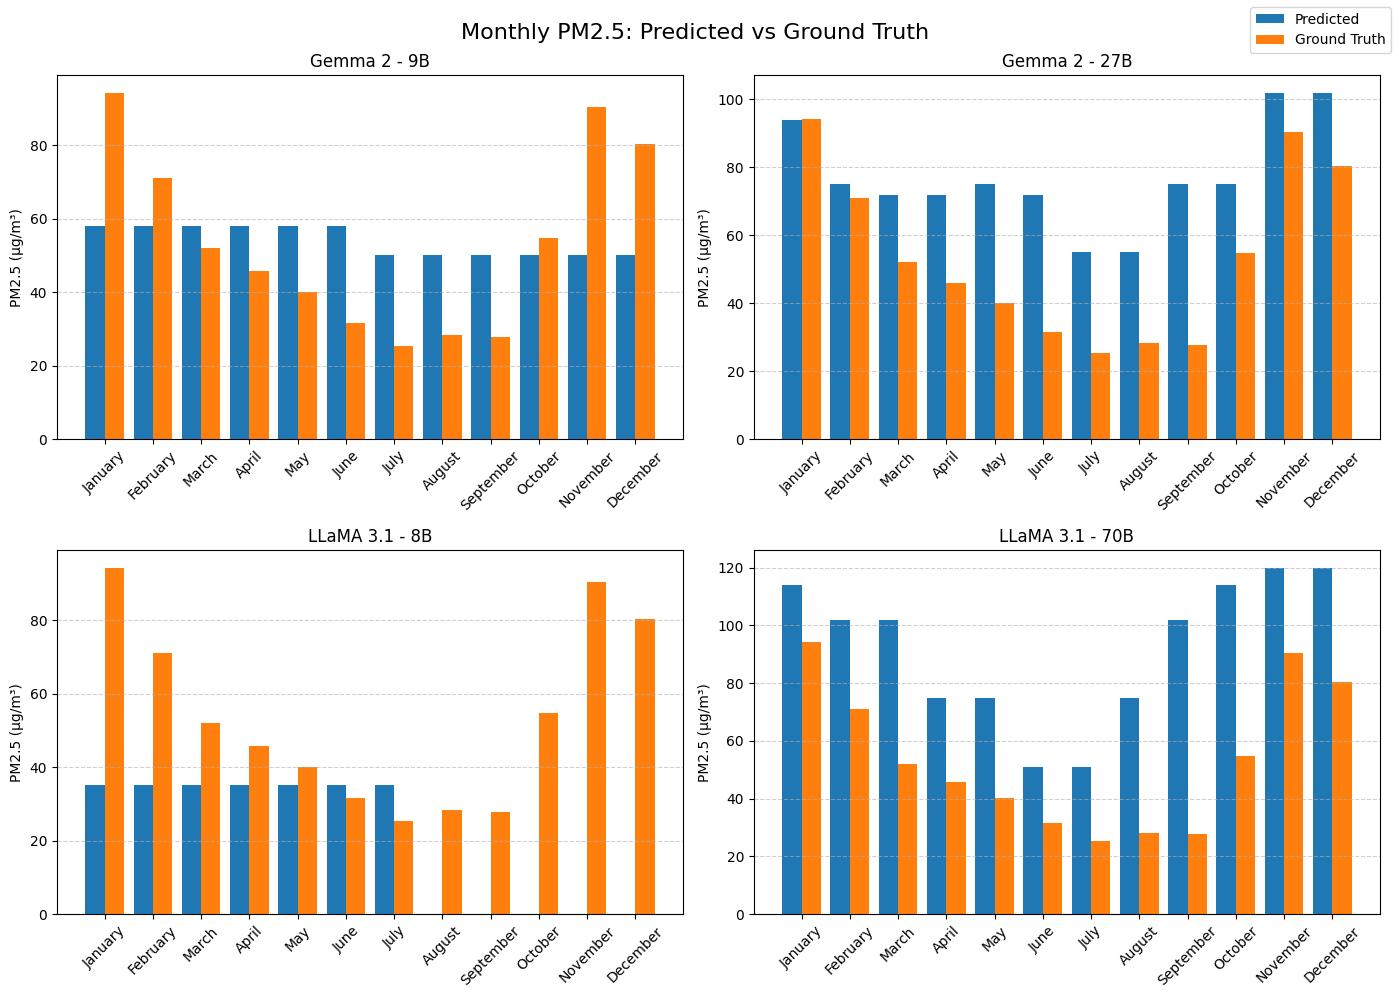

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

month_order = ["January", "February", "March", "April", "May", "June",
               "July", "August", "September", "October", "November", "December"]

def prepare_comparison_df(model_df, ground_truth_df):
    model_df = model_df.copy()
    ground_truth_df = ground_truth_df.copy()

    model_df['month'] = pd.Categorical(model_df['month'], categories=month_order, ordered=True)
    ground_truth_df['month'] = pd.Categorical(ground_truth_df['month'], categories=month_order, ordered=True)

    model_df = model_df.sort_values('month').rename(columns={'pm2.5': 'Predicted_PM2.5'})
    ground_truth_df = ground_truth_df.sort_values('month').rename(columns={'PM2.5': 'GroundTruth_PM2.5'})

    merged = pd.merge(model_df[['month', 'Predicted_PM2.5']],
                      ground_truth_df[['month', 'GroundTruth_PM2.5']],
                      on='month', how='inner')
    return merged

def plot_monthly_comparison_grid(model_data_list, ground_truth_df):
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    axs = axs.flatten()  # Convert 2x2 to 1D array for easy indexing

    for idx, (model_df, model_name) in enumerate(model_data_list):
        merged = prepare_comparison_df(model_df, ground_truth_df)
        x = range(len(merged))
        width = 0.4

        axs[idx].bar([i - width/2 for i in x], merged['Predicted_PM2.5'], width=width, label='Predicted')
        axs[idx].bar([i + width/2 for i in x], merged['GroundTruth_PM2.5'], width=width, label='Ground Truth')

        axs[idx].set_title(f"{model_name}")
        axs[idx].set_xticks(x)
        axs[idx].set_xticklabels(merged['month'], rotation=45)
        axs[idx].set_ylabel("PM2.5 (μg/m³)")
        axs[idx].grid(axis='y', linestyle='--', alpha=0.6)

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels)
    fig.suptitle("Monthly PM2.5: Predicted vs Ground Truth", fontsize=16)
    plt.tight_layout()
    plt.show()

# ==== Call the function with 4 models ====
model_data = [
    (gemma_9b_df_national, "Gemma 2 - 9B"),
    (gemma_27b_df_national, "Gemma 2 - 27B"),
    (llama_8b_df_national, "LLaMA 3.1 - 8B"),
    (llama_70b_df_national, "LLaMA 3.1 - 70B")
]

plot_monthly_comparison_grid(model_data, ground_truth_national_df)

#### City Level

In [6]:
ground_truth_df.head()

,city,state,year,month,YearMonth,ground_truth_pm25
0,Agra,Uttar Pradesh,2023,January,2023-01-01,44.641356
1,Agra,Uttar Pradesh,2023,February,2023-02-01,19.689583
2,Agra,Uttar Pradesh,2023,March,2023-03-01,16.330529
3,Agra,Uttar Pradesh,2023,April,2023-04-01,17.066000
4,Agra,Uttar Pradesh,2023,May,2023-05-01,23.099587


In [7]:
ground_truth_df['state'].nunique()

24

In [15]:
def compute_city_correlations(model_df, ground_truth_df):
    model_df = model_df.copy()
    ground_df = ground_truth_df.copy()

    for df in [model_df, ground_df]:
        df['city_lower'] = df['city'].str.strip().str.lower()
        df['state_lower'] = df['state'].str.strip().str.lower()
        df['month_lower'] = df['month'].str.strip().str.lower()
        df['year'] = df['year'].astype(int)

    merged = pd.merge(
        model_df,
        ground_df,
        left_on=['city_lower', 'state_lower', 'year', 'month_lower'],
        right_on=['city_lower', 'state_lower', 'year', 'month_lower'],
        how='inner'
    )
    
    correlations = []
    for city in merged['city_lower'].unique():
        sub = merged[merged['city_lower'] == city]
        if len(sub) == 12 and sub['pm2.5'].nunique() > 1 and sub['ground_truth_pm25'].nunique() > 1:
            corr, _ = pearsonr(sub['pm2.5'], sub['ground_truth_pm25'])
            correlations.append({'city': city, 'correlation': corr})
    return pd.DataFrame(correlations)

corr_gemma_9b = compute_city_correlations(gemma_9b_df, ground_truth_df)
corr_gemma_27b = compute_city_correlations(gemma_27b_df, ground_truth_df)
corr_llama_8b = compute_city_correlations(llama_8b_df, ground_truth_df)
corr_llama_70b = compute_city_correlations(llama_70b_df, ground_truth_df)

print("Gemma 9B:", len(corr_gemma_9b))
print("Gemma 27B:", len(corr_gemma_27b))
print("LLaMA 8B:", len(corr_llama_8b))
print("LLaMA 70B:", len(corr_llama_70b))

print(corr_llama_8b['correlation'].describe())
print(corr_llama_8b['correlation'].isna().sum())


model_corrs = [
    (corr_gemma_9b, "Gemma 2 - 9B", 'blue'),
    (corr_gemma_27b, "Gemma 2 - 27B", 'green'),
    (corr_llama_8b, "LLaMA 3.1 - 8B", 'red'),
    (corr_llama_70b, "LLaMA 3.3 - 70B", 'purple')
]

for ax, (corr_df, title, color) in zip(axs.flatten(), model_corrs):
    sns.histplot(corr_df['correlation'], bins=20, kde=True, color=color, ax=ax, alpha=0.6)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Pearson Correlation")
    ax.set_ylabel("Number of Cities")
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()

Gemma 9B: 198
Gemma 27B: 199
LLaMA 8B: 171
LLaMA 70B: 198
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: correlation, dtype: float64
171


<Figure size 640x480 with 0 Axes>

In [7]:
from scipy.stats import spearmanr, kendalltau, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# === Helper: Partial Order Agreement ===
def partial_order_agreement(x, y):
    count_agree = 0
    total = 0
    n = len(x)
    for i in range(n):
        for j in range(i+1, n):
            if x[i] == x[j] or y[i] == y[j]:
                continue
            total += 1
            if (x[i] - x[j]) * (y[i] - y[j]) > 0:
                count_agree += 1
    return count_agree / total if total > 0 else None

# === Compute correlations per city for a model ===
def compute_city_correlations(model_df, ground_truth_df):
    model_df = model_df.copy()
    ground_df = ground_truth_df.copy()

    for df in [model_df, ground_df]:
        df['city_lower'] = df['city'].str.strip().str.lower()
        df['state_lower'] = df['state'].str.strip().str.lower()
        df['month_lower'] = df['month'].str.strip().str.lower()
        df['year'] = df['year'].astype(int)

    merged = pd.merge(
        model_df,
        ground_df,
        on=['city_lower', 'state_lower', 'year', 'month_lower'],
        how='inner'
    )

    correlations = []
    for city in merged['city_lower'].unique():
        sub = merged[merged['city_lower'] == city]
        if len(sub) == 12 and sub['pm2.5'].nunique() > 1 and sub['ground_truth_pm25'].nunique() > 1:
            x = sub['pm2.5'].values
            y = sub['ground_truth_pm25'].values
            correlations.append({
                'city': city,
                'Pearson': pearsonr(x, y)[0],
                'Spearman': spearmanr(x, y)[0],
                'KendallTau': kendalltau(x, y)[0],
                'PartialOrderAgreement': partial_order_agreement(x, y)
            })
    return pd.DataFrame(correlations)


In [10]:
corr_gemma_9b = compute_city_correlations(gemma_9b_df, ground_truth_df)
corr_gemma_27b = compute_city_correlations(gemma_27b_df, ground_truth_df)
corr_llama_8b = compute_city_correlations(llama_8b_df, ground_truth_df)
corr_llama_70b = compute_city_correlations(llama_70b_df, ground_truth_df)


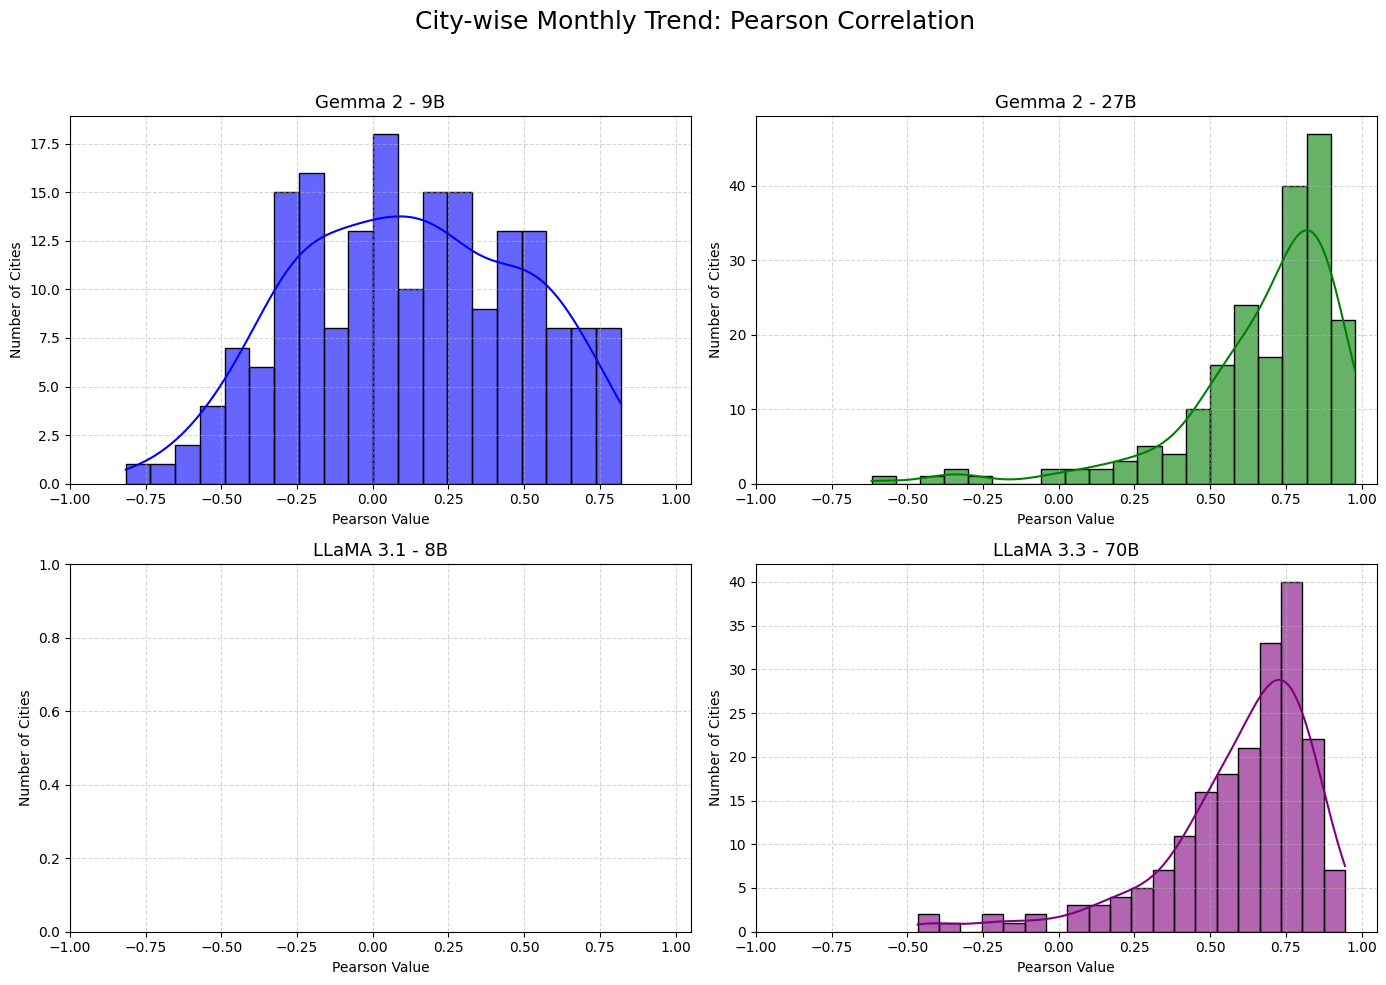

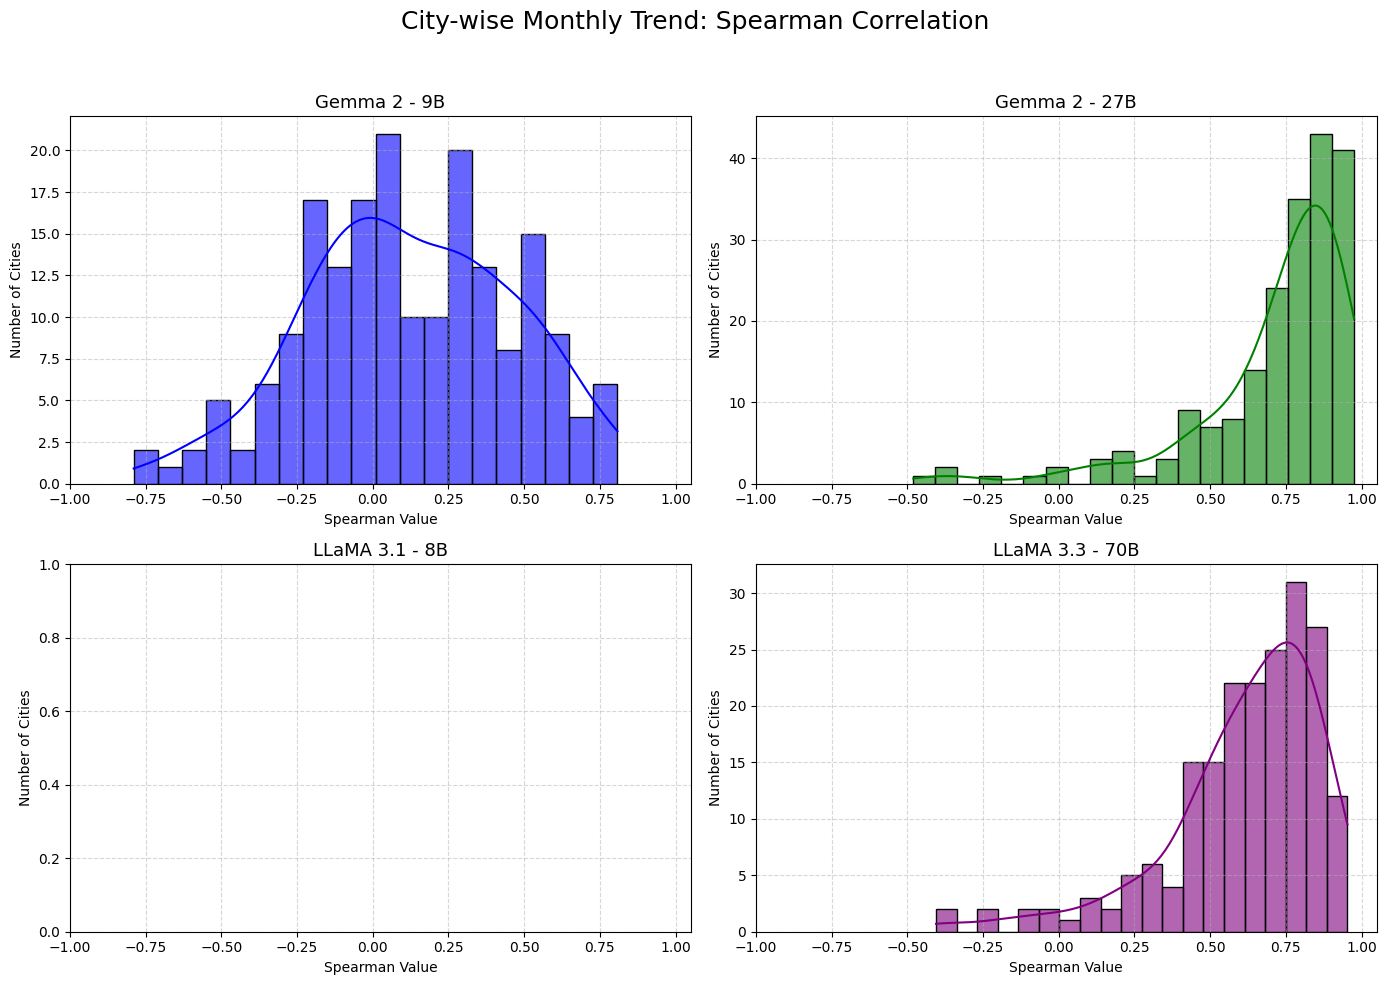

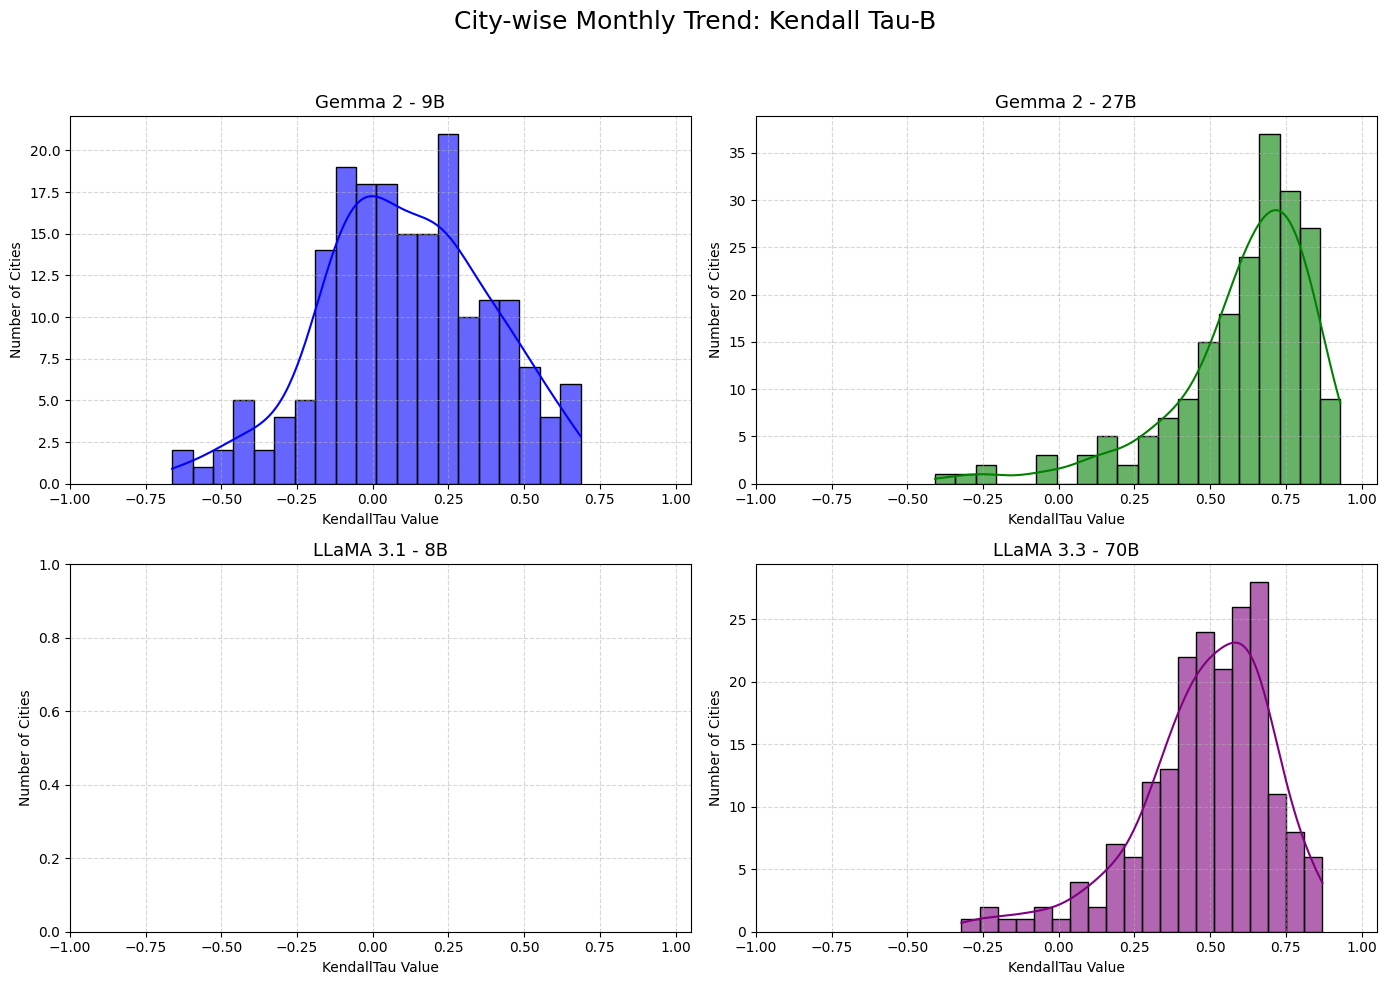

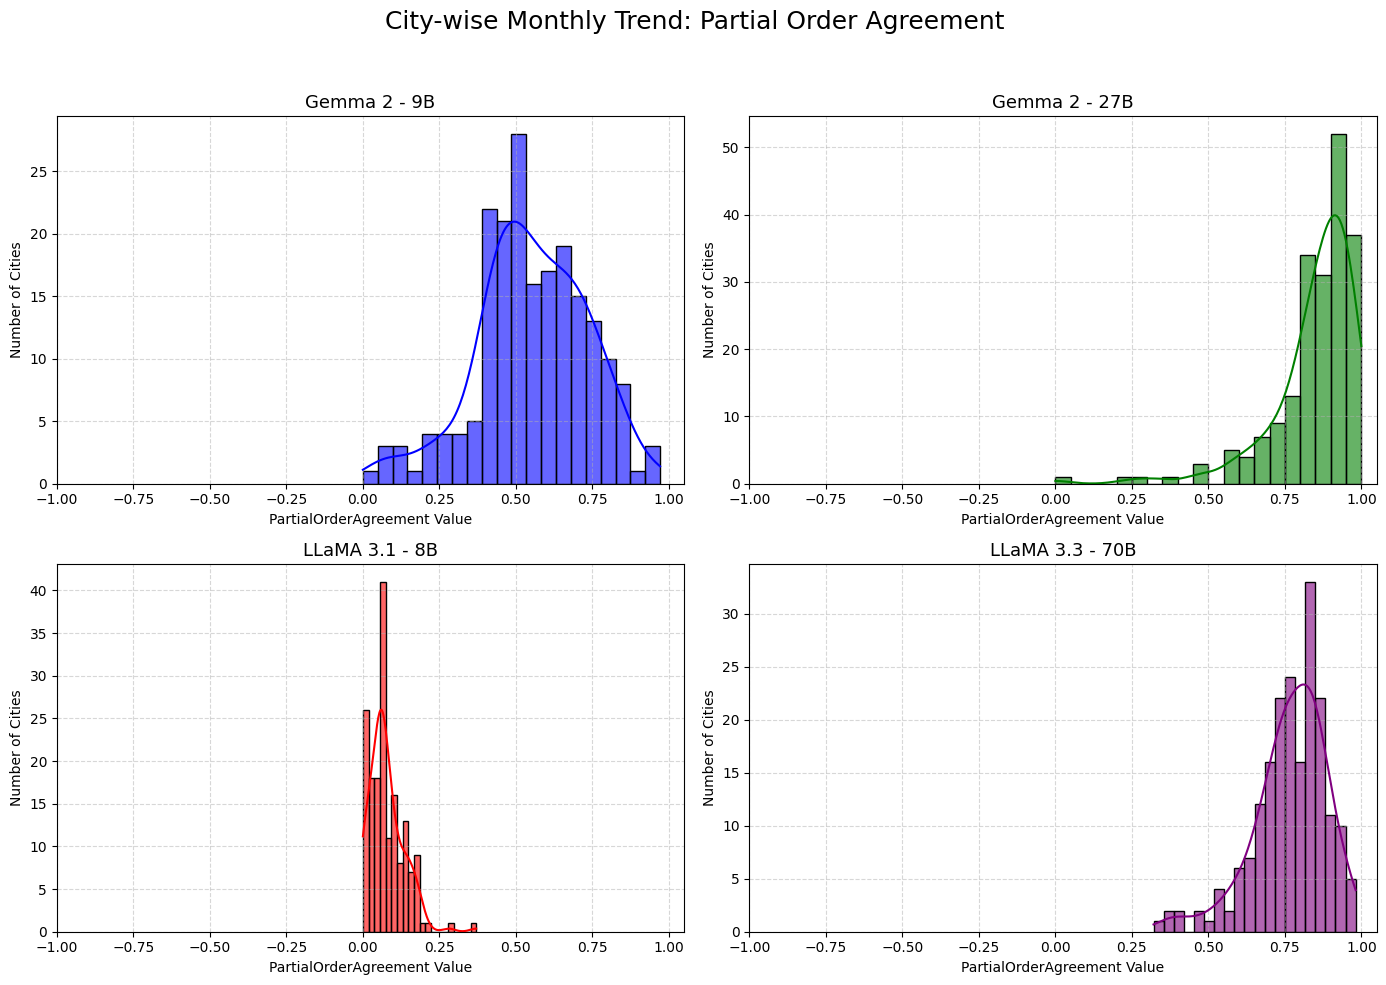

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# === Models and metrics ===
model_corrs = [
    (corr_gemma_9b, "Gemma 2 - 9B", 'blue'),
    (corr_gemma_27b, "Gemma 2 - 27B", 'green'),
    (corr_llama_8b, "LLaMA 3.1 - 8B", 'red'),
    (corr_llama_70b, "LLaMA 3.3 - 70B", 'purple')
]

metrics = ['Pearson', 'Spearman', 'KendallTau', 'PartialOrderAgreement']
metric_titles = {
    'Pearson': "Pearson Correlation",
    'Spearman': "Spearman Correlation",
    'KendallTau': "Kendall Tau-B",
    'PartialOrderAgreement': "Partial Order Agreement"
}

# === Plot each metric in a separate 2x2 plot ===
for metric in metrics:
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"City-wise Monthly Trend: {metric_titles[metric]}", fontsize=18)

    for ax, (corr_df, model_name, color) in zip(axs.flat, model_corrs):
        if metric in corr_df.columns:
            sns.histplot(
                corr_df[metric].dropna(),
                bins=20, kde=True, color=color, ax=ax,
                alpha=0.6
            )
            ax.set_title(model_name, fontsize=13)
            ax.set_xlim(-1.0, 1.05)
            ax.set_xlabel(f"{metric} Value")
            ax.set_ylabel("Number of Cities")
            ax.grid(True, linestyle='--', alpha=0.5)
        else:
            ax.text(0.5, 0.5, "Metric Missing", ha='center', va='center')
            ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


### With Non Zero temperature

In [45]:
gt_df = pd.read_csv("AirQuality/Dataset/Ground_Truth_2023_Final.csv")
gt_df['YearMonth'] = pd.to_datetime(gt_df['YearMonth'])
gt_df['year'] = gt_df['YearMonth'].dt.year
gt_df['month'] = gt_df['YearMonth'].dt.strftime('%B')

gt_df = gt_df.rename(columns={'PM2.5': 'ground_truth_pm25'})

gt_df = gt_df[['city', 'state', 'year', 'month', 'YearMonth', 'ground_truth_pm25']]

In [15]:
gt_df.head()

,city,state,year,month,YearMonth,ground_truth_pm25
0,Agartala,Tripura,2023,January,2023-01-01,196.040103
1,Agartala,Tripura,2023,February,2023-02-01,170.874875
2,Agartala,Tripura,2023,March,2023-03-01,119.490881
3,Agartala,Tripura,2023,April,2023-04-01,94.205356
4,Agartala,Tripura,2023,May,2023-05-01,63.553585


In [4]:
gt_df['state'].nunique()

29

In [38]:
model_paths = {
    "gemma2-9b-it": "AirQuality/RQ1/Dataset/With_Temperature/gemma2_9b_it_2023_With_Temp.csv",
    "gemma2-27b-it": "AirQuality/RQ1/Dataset/With_Temperature/gemma2_27b_it_2023_With_Temp.csv",
    "llama3-8b-Instruct": "AirQuality/RQ1/Dataset/With_Temperature/llama3_8b_it_2023_With_Temp.csv",
    "llama3-70b-Instruct": "AirQuality/RQ1/Dataset/With_Temperature/llama3_70b_it_2023_With_Temp.csv",
    "qwen3-32b": "AirQuality/RQ1/Dataset/With_Temperature/qwen3_32b_2023_With_Temp.csv"
}

In [19]:
def load_and_analyze(model_name, path):
    df = pd.read_csv(path)
    # Standardize column names
    df.columns = [col.lower().replace('pm2.5_', 'pm25_') for col in df.columns]
    pm25_cols = [col for col in df.columns if col.startswith('pm25_')]
    
    # Flatten all predictions to calculate global stats
    preds_flat = df[pm25_cols].values.flatten()
    preds_flat_series = pd.Series(preds_flat)
    
    total = len(preds_flat)
    invalid = ((preds_flat_series < 0) | (preds_flat_series > 500)).sum()
    invalid_pct = 100 * invalid / total
    
    # Calculate variance and std dev per city-month (row)
    df['pred_variance'] = df[pm25_cols].var(axis=1)
    df['pred_std'] = df[pm25_cols].std(axis=1)
    
    # Summarize variance/std dev across all city-months
    mean_variance = df['pred_variance'].mean()
    median_variance = df['pred_variance'].median()
    mean_std = df['pred_std'].mean()
    median_std = df['pred_std'].median()
    
    return {
        "Model": model_name,
        "Total Predictions": total,
        "Min": preds_flat_series.min(),
        "Max": preds_flat_series.max(),
        "% Invalid (<0 or >500)": round(invalid_pct, 3),
        "Mean": preds_flat_series.mean(),
        "Std Dev": preds_flat_series.std(),
        "Mean Variance (per city-month)": mean_variance,
        "Median Variance (per city-month)": median_variance,
        "Mean Std Dev (per city-month)": mean_std,
        "Median Std Dev (per city-month)": median_std
    }

# Analyze all models and collect results
results = []
for model_name, path in model_paths.items():
    res = load_and_analyze(model_name, path)
    results.append(res)

# Convert to DataFrame for display
rq1_1_df = pd.DataFrame(results)
rq1_1_df


,Model,Total Predictions,Min,Max,% Invalid (<0 or >500),Mean,Std Dev,Mean Variance (per city-month),Median Variance (per city-month),Mean Std Dev (per city-month),Median Std Dev (per city-month)
0,gemma2-9b-it,24120,4.5,325.0,0.0,52.983006,28.053469,333.922019,132.864500,15.054655,11.526686
1,gemma2-27b-it,24120,17.0,301.0,0.0,75.821882,32.158559,120.313981,87.155556,9.744531,9.335714
2,llama3-8b-Instruct,24120,2.0,151.0,0.0,24.542841,14.896274,113.933326,62.650000,8.466395,7.915170
3,llama3-70b-Instruct,24120,10.0,254.0,0.0,91.631509,48.335597,164.627474,29.566667,8.227205,5.437524
4,qwen3-32b,24120,14.5,420.5,0.0,61.588698,36.459884,373.713734,57.951556,13.248435,7.612574


In [43]:
gt_mean = gt_df["ground_truth_pm25"].mean()
gt_std = gt_df["ground_truth_pm25"].std()

print(f"Ground Truth Mean PM2.5: {gt_mean:.2f}")
print(f"Ground Truth Std Dev PM2.5: {gt_std:.2f}")

Ground Truth Mean PM2.5: 49.15
Ground Truth Std Dev PM2.5: 36.84


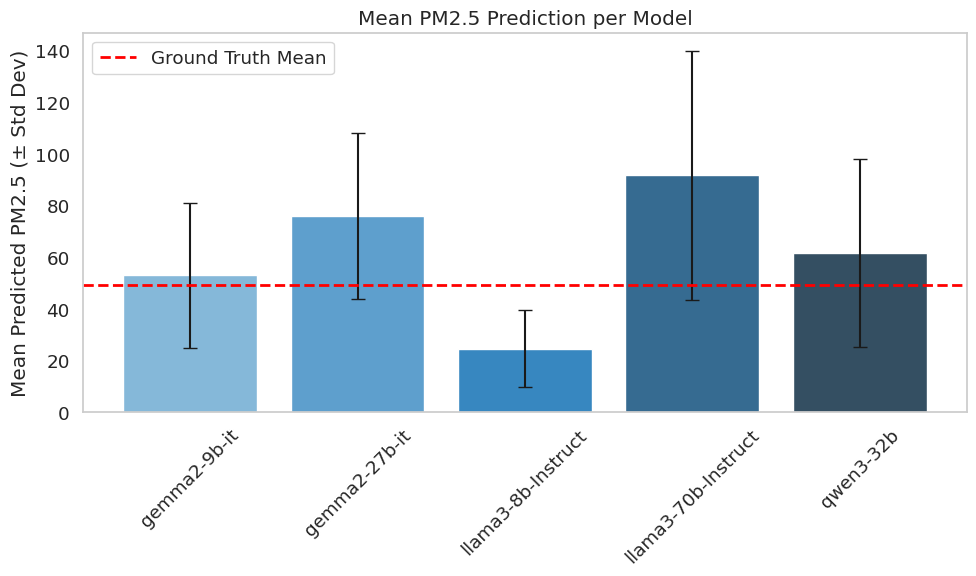

In [73]:
sns.set_theme(style="whitegrid", font_scale=1.2)

# Ground truth
gt_mean = 49.15

# Prepare data
models = rq1_1_df["Model"]
means = rq1_1_df["Mean"]
stds = rq1_1_df["Std Dev"]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(models, means, yerr=stds, capsize=5, color=sns.color_palette("Blues_d", n_colors=len(models)))

# Add Ground Truth Mean line
plt.axhline(gt_mean, color='red', linestyle='--', linewidth=2, label='Ground Truth Mean')

# Labels and title
plt.ylabel("Mean Predicted PM2.5 (± Std Dev)")
plt.title("Mean PM2.5 Prediction per Model")
plt.xticks(rotation=45)
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_3727658/759664087.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=combined_df, x="Model", y="StdDev", inner="box", palette="pastel")


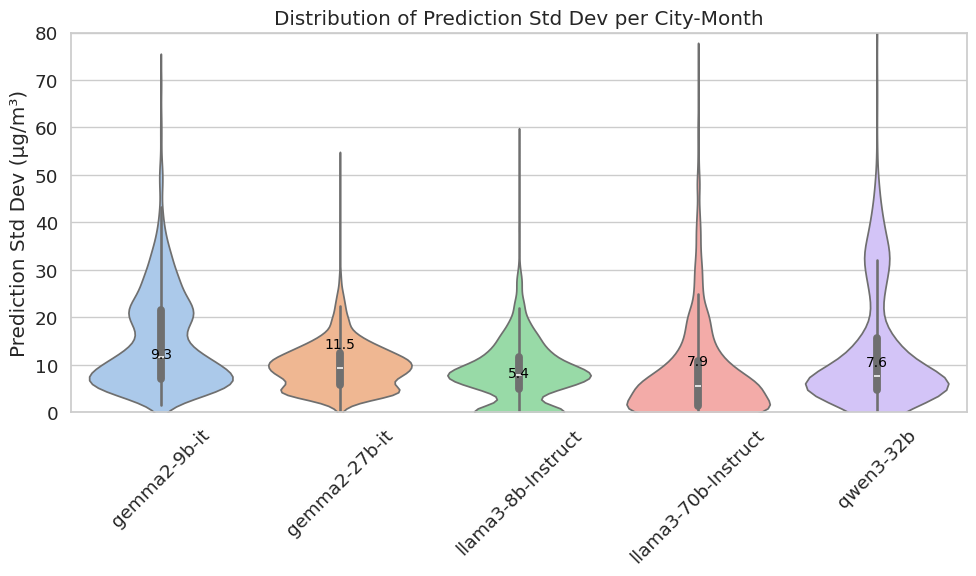

In [39]:
sns.set_theme(style="whitegrid", font_scale=1.2)

# === Load & Prepare Data ===
all_data = []
for model in rq1_1_df["Model"]:
    df = pd.read_csv(model_paths[model])
    df.columns = [col.lower().replace('pm2.5_', 'pm25_') for col in df.columns]
    pm25_cols = [col for col in df.columns if col.startswith('pm25_')]
    
    # Std Dev across 10 predictions per city-month
    df["std_dev"] = df[pm25_cols].std(axis=1)

    temp_df = pd.DataFrame({
        "Model": model,
        "StdDev": df["std_dev"].values
    }).reset_index(drop=True)
    
    all_data.append(temp_df)

combined_df = pd.concat(all_data, ignore_index=True)

# === Violin Plot ===
plt.figure(figsize=(10, 6))
sns.violinplot(data=combined_df, x="Model", y="StdDev", inner="box", palette="pastel")

# Title & Labels
plt.title("Distribution of Prediction Std Dev per City-Month")
plt.ylabel("Prediction Std Dev (μg/m³)")
plt.xlabel("")
plt.xticks(rotation=45)

# Annotate medians above violins
medians = combined_df.groupby("Model")["StdDev"].median()
for i, (model, median_val) in enumerate(medians.items()):
    plt.text(i, median_val + 2, f"{median_val:.1f}", ha='center', fontsize=10, color='black')

# Optional: Limit y-axis for cleaner focus
plt.ylim(0, 80)

plt.tight_layout()
plt.show()

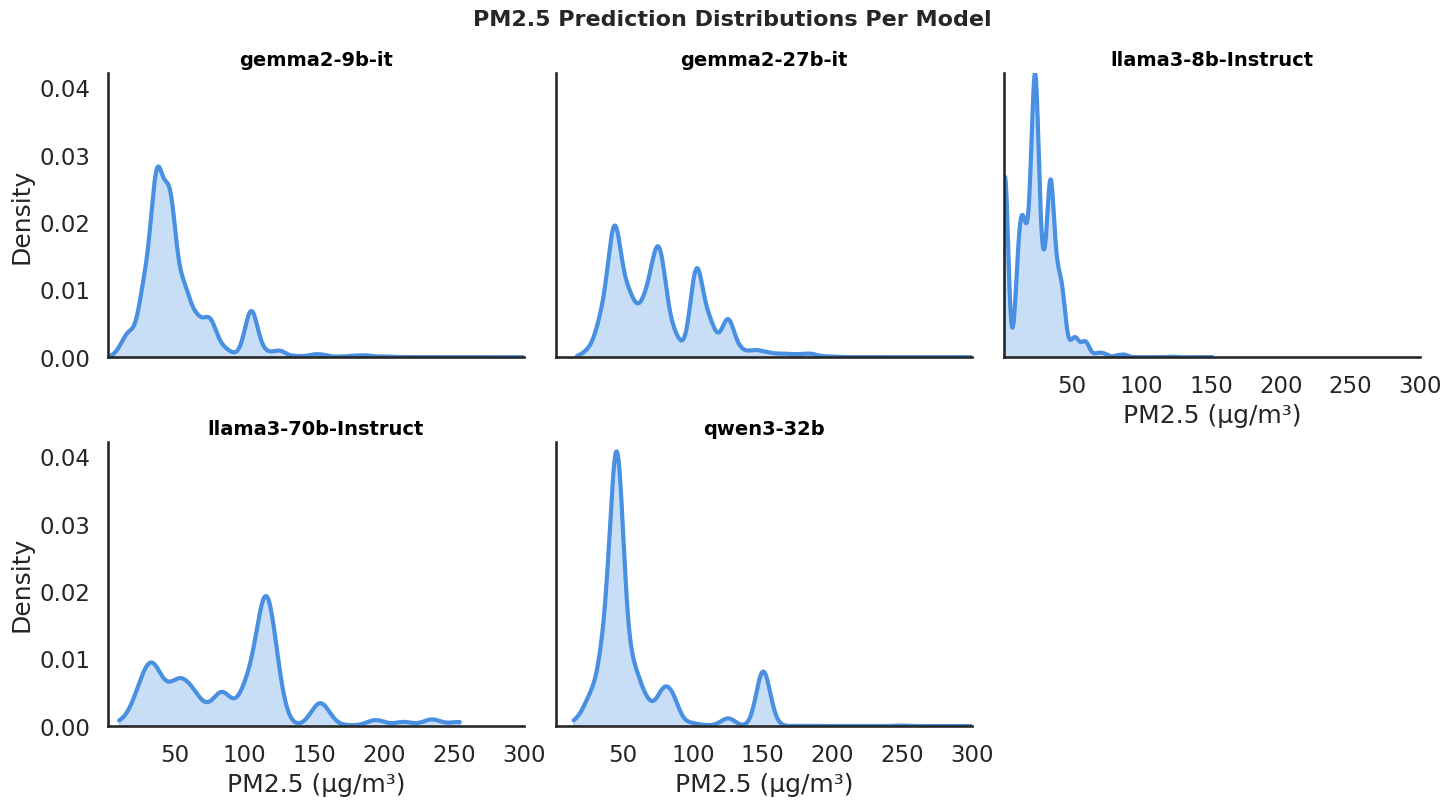

In [50]:
all_preds = []
global_min = float("inf")
global_max = float("-inf")

model_paths = {
    "gemma2-9b-it": "AirQuality/RQ1/Dataset/With_Temperature/gemma2_9b_it_2023_With_Temp.csv",
    "gemma2-27b-it": "AirQuality/RQ1/Dataset/With_Temperature/gemma2_27b_it_2023_With_Temp.csv",
    "llama3-8b-Instruct": "AirQuality/RQ1/Dataset/With_Temperature/llama3_8b_it_2023_With_Temp.csv",
    "llama3-70b-Instruct": "AirQuality/RQ1/Dataset/With_Temperature/llama3_70b_it_2023_With_Temp.csv",
    "qwen3-32b": "AirQuality/RQ1/Dataset/With_Temperature/qwen3_32b_2023_With_Temp.csv"
}

for model_name, path in model_paths.items():
    df = pd.read_csv(path)
    # Normalize column names
    df.columns = [col.lower().replace('pm2.5_', 'pm25_') for col in df.columns]
    pm25_cols = [col for col in df.columns if col.startswith('pm25_')]
    
    # Flatten all iterations
    preds = df[pm25_cols].values.flatten()
    
    # Update global min and max
    global_min = min(global_min, preds.min())
    global_max = max(global_max, preds.max())
    
    model_df = pd.DataFrame({'Prediction': preds, 'Model': model_name})
    all_preds.append(model_df)

# # Combine into one DataFrame
plot_df = pd.concat(all_preds, ignore_index=True)

# === Prepare KDE data ===
kde_data = []
for model in plot_df['Model'].unique():
    values = plot_df[plot_df['Model'] == model]['Prediction'].dropna().values
    kde = gaussian_kde(values)
    # x_vals = np.linspace(values.min(), values.max(), 1000)
    x_vals = np.linspace(values.min(), min(values.max(), 300), 1000)
    y_vals = kde(x_vals)

    temp_df = pd.DataFrame({
        'x': x_vals,
        'y': y_vals,
        'Model': model
    })
    kde_data.append(temp_df)

kde_plot_df = pd.concat(kde_data, ignore_index=True)

# === Aesthetics ===
sns.set_context("talk", font_scale=1.0)
sns.set_style("white")  # No gridlines

# === Set color for all KDEs ===
kde_color = "#4A90E2"

# === Determine global min/max for consistent axes ===
x_min = kde_plot_df['x'].min()
# x_max = kde_plot_df['x'].max()
x_max = min(kde_plot_df['x'].max(), 300)
y_max = kde_plot_df['y'].max()

# === Faceted Plot ===
g = sns.FacetGrid(kde_plot_df, col="Model", col_wrap=3, height=4, aspect=1.2, sharex=True, sharey=True)

def plot_filled_kde(data, color, **kwargs):
    plt.fill_between(data["x"], data["y"], alpha=0.3, color=color)
    plt.plot(data["x"], data["y"], color=color, linewidth=3)

g.map_dataframe(plot_filled_kde, color=kde_color)

# Customize subplots
for ax, model_name in zip(g.axes.flatten(), kde_plot_df['Model'].unique()):
    ax.set_title(f"{model_name}", fontsize=14, weight='semibold', color='black')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, y_max)


# Axis labels
g.set_axis_labels("PM2.5 (μg/m³)", "Density")

# Layout adjustments
plt.subplots_adjust(top=0.9, hspace=0.3)
g.figure.suptitle("PM2.5 Prediction Distributions Per Model", fontsize=16, weight='bold')

plt.show()

> With 0 temerature results

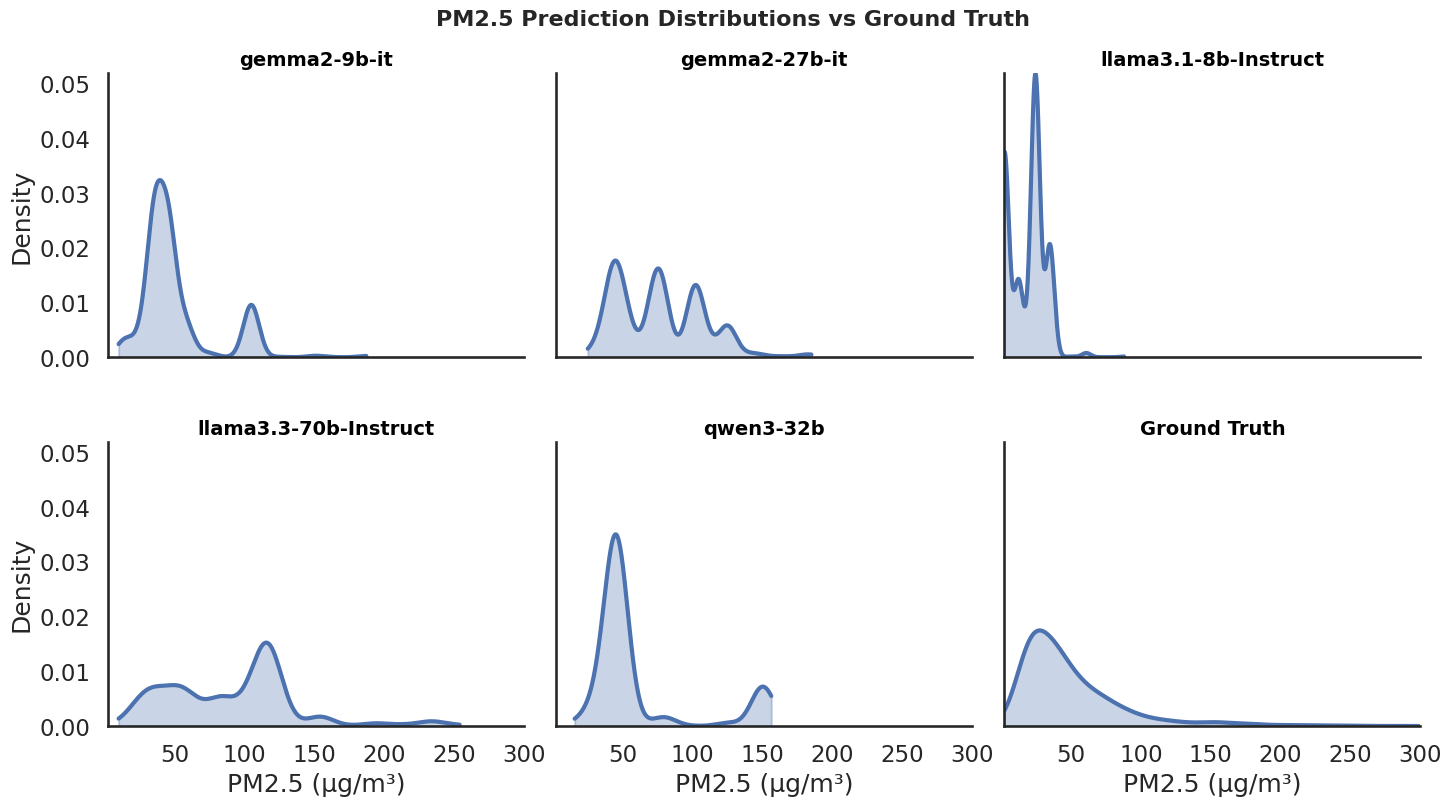

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

# === Load data ===
# gt_df = pd.read_csv("AirQuality/Dataset/Ground_Truth_2023_Final.csv")
gt_values = gt_df["ground_truth_pm25"].dropna().values

model_dfs = {
    "gemma2-9b-it": pd.read_csv("AirQuality/RQ1/Dataset/Predictions/gemma2_9b_it_2023_predictions.csv"),
    "gemma2-27b-it": pd.read_csv("AirQuality/RQ1/Dataset/Predictions/gemma2_27b_it_2023_predictions.csv"),
    "llama3.1-8b-Instruct": pd.read_csv("AirQuality/RQ1/Dataset/Predictions/llama3_8b_it_2023_predictions.csv"),
    "llama3.3-70b-Instruct": pd.read_csv("AirQuality/RQ1/Dataset/Predictions/llama3_70b_it_2023_predictions.csv"),
    "qwen3-32b": pd.read_csv("AirQuality/RQ1/Dataset/Predictions/qwen3_32b_2023_predictions.csv")
}

# === Set model order including GT ===
model_order = list(model_dfs.keys()) + ["Ground Truth"]

# === KDE data prep ===
kde_data = []

# Ground truth
gt_kde = gaussian_kde(gt_values)
x_vals = np.linspace(gt_values.min(), min(gt_values.max(), 300), 1000)
y_vals = gt_kde(x_vals)
kde_data.append(pd.DataFrame({
    "x": x_vals,
    "y": y_vals,
    "Model": ["Ground Truth"] * len(x_vals)
}))

# Predictions
for model_name, df in model_dfs.items():
    preds = df["pm2.5"].dropna().values
    kde = gaussian_kde(preds)
    x_vals = np.linspace(preds.min(), min(preds.max(), 300), 1000)
    y_vals = kde(x_vals)
    kde_data.append(pd.DataFrame({
        "x": x_vals,
        "y": y_vals,
        "Model": [model_name] * len(x_vals)
    }))

# === Combine and enforce categorical order ===
kde_plot_df = pd.concat(kde_data, ignore_index=True)
kde_plot_df["Model"] = pd.Categorical(kde_plot_df["Model"], categories=model_order, ordered=True)

# === Aesthetics ===
sns.set_context("talk", font_scale=1.0)
sns.set_style("white")

# === Plot ===
g = sns.FacetGrid(
    kde_plot_df,
    col="Model",
    col_wrap=3,
    height=4,
    aspect=1.2,
    sharex=True,
    sharey=True
)

def plot_filled_kde(data, color="#4A90E2", **kwargs):
    plt.fill_between(data["x"], data["y"], alpha=0.3, color=color)
    plt.plot(data["x"], data["y"], color=color, linewidth=3)

g.map_dataframe(plot_filled_kde)

# Set global limits
x_min = kde_plot_df['x'].min()
x_max = min(kde_plot_df['x'].max(), 300)
y_max = kde_plot_df['y'].max()

# Apply limits and titles
for ax, model_name in zip(g.axes.flatten(), model_order):
    ax.set_title(f"{model_name}", fontsize=14, weight='semibold', color='black')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, y_max)

g.set_axis_labels("PM2.5 (μg/m³)", "Density")

plt.subplots_adjust(top=0.9, hspace=0.3)
g.figure.suptitle("PM2.5 Prediction Distributions vs Ground Truth", fontsize=16, weight='bold')

plt.show()

> Combined plot of KDE

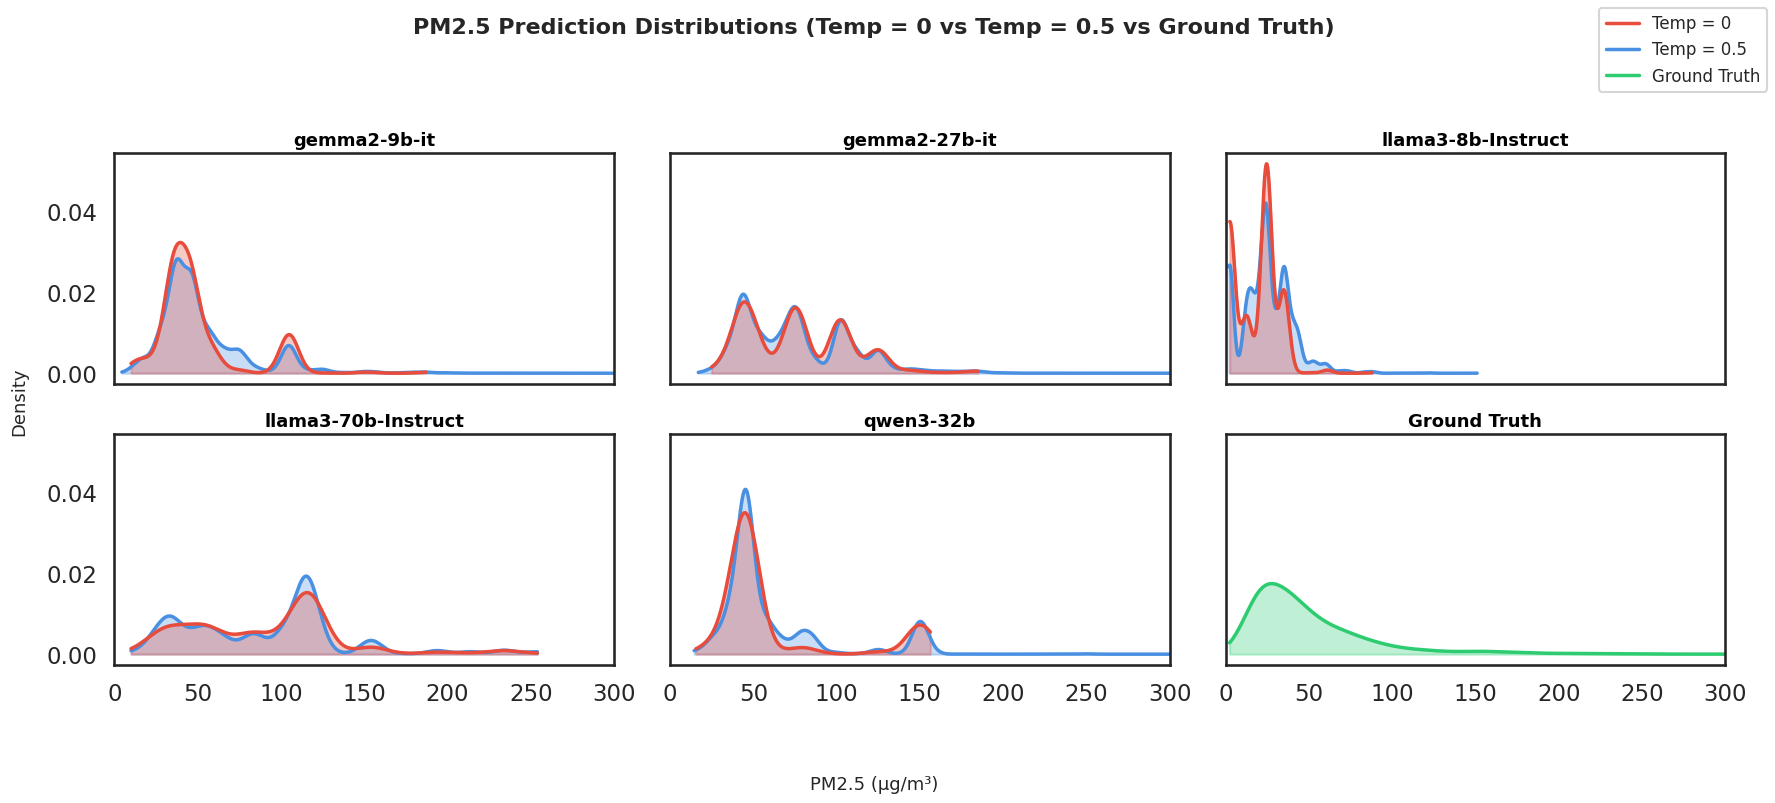

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

# === File paths ===
with_temp_paths = {
    "gemma2-9b-it": "AirQuality/RQ1/Dataset/With_Temperature/gemma2_9b_it_2023_With_Temp.csv",
    "gemma2-27b-it": "AirQuality/RQ1/Dataset/With_Temperature/gemma2_27b_it_2023_With_Temp.csv",
    "llama3-8b-Instruct": "AirQuality/RQ1/Dataset/With_Temperature/llama3_8b_it_2023_With_Temp.csv",
    "llama3-70b-Instruct": "AirQuality/RQ1/Dataset/With_Temperature/llama3_70b_it_2023_With_Temp.csv",
    "qwen3-32b": "AirQuality/RQ1/Dataset/With_Temperature/qwen3_32b_2023_With_Temp.csv"
}

zero_temp_paths = {
    "gemma2-9b-it": "AirQuality/RQ1/Dataset/Predictions/gemma2_9b_it_2023_predictions.csv",
    "gemma2-27b-it": "AirQuality/RQ1/Dataset/Predictions/gemma2_27b_it_2023_predictions.csv",
    "llama3-8b-Instruct": "AirQuality/RQ1/Dataset/Predictions/llama3_8b_it_2023_predictions.csv",
    "llama3-70b-Instruct": "AirQuality/RQ1/Dataset/Predictions/llama3_70b_it_2023_predictions.csv",
    "qwen3-32b": "AirQuality/RQ1/Dataset/Predictions/qwen3_32b_2023_predictions.csv"
}

# === Load Ground Truth ===
gt_df = pd.read_csv("AirQuality/Dataset/Ground_Truth_2023_Final.csv")
gt_df['YearMonth'] = pd.to_datetime(gt_df['YearMonth'])
gt_df['year'] = gt_df['YearMonth'].dt.year
gt_df['month'] = gt_df['YearMonth'].dt.strftime('%B')

gt_df = gt_df.rename(columns={'PM2.5': 'ground_truth_pm25'})

gt_df = gt_df[['city', 'state', 'year', 'month', 'YearMonth', 'ground_truth_pm25']]
gt_values = gt_df["ground_truth_pm25"].dropna().values

# === Helper: KDE computation ===
def compute_kde(data):
    data = data[np.isfinite(data)]
    if len(data) < 2:
        return None
    kde = gaussian_kde(data)
    x_vals = np.linspace(data.min(), min(data.max(), 300), 1000)
    y_vals = kde(x_vals)
    return x_vals, y_vals

# === Plot settings ===
sns.set_context("talk")
sns.set_style("white")
model_list = list(with_temp_paths.keys())
colors = {"Temp = 0": "#E74C3C", "Temp = 0.5": "#4A90E2", "Ground Truth": "#2ECC71"}

# === Create subplots: 2 rows, 3 columns ===
fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True)
axes = axes.flatten()

# === Model-wise plots ===
for idx, model in enumerate(model_list):
    ax = axes[idx]

    # Load predictions for Temp = 0.5
    df_temp = pd.read_csv(with_temp_paths[model])
    df_temp.columns = [col.lower().replace("pm2.5_", "pm25_") for col in df_temp.columns]
    pm25_cols = [col for col in df_temp.columns if col.startswith("pm25_")]
    preds_temp = df_temp[pm25_cols].values.flatten()
    kde_temp = compute_kde(preds_temp)

    # Load predictions for Temp = 0
    df_zero = pd.read_csv(zero_temp_paths[model])
    preds_zero = df_zero["pm2.5"].dropna().values
    kde_zero = compute_kde(preds_zero)

    # Plot both KDEs
    if kde_temp is not None:
        x_temp, y_temp = kde_temp
        ax.fill_between(x_temp, y_temp, alpha=0.3, color=colors["Temp = 0.5"])
        ax.plot(x_temp, y_temp, color=colors["Temp = 0.5"], label="Temp = 0.5", linewidth=2.5)
    if kde_zero is not None:
        x_zero, y_zero = kde_zero
        ax.fill_between(x_zero, y_zero, alpha=0.3, color=colors["Temp = 0"])
        ax.plot(x_zero, y_zero, color=colors["Temp = 0"], label="Temp = 0", linewidth=2.5)

    ax.set_title(model, fontsize=13, weight='semibold', color='black')
    ax.set_xlim(0, 300)

# === Ground Truth in last subplot ===
ax = axes[-1]
kde_gt = compute_kde(gt_values)

if kde_gt is not None:
    x_gt, y_gt = kde_gt
    ax.fill_between(x_gt, y_gt, alpha=0.3, color=colors["Ground Truth"])
    ax.plot(x_gt, y_gt, color=colors["Ground Truth"], label="Ground Truth", linewidth=2.5)
    ax.set_title("Ground Truth", fontsize=13, weight='semibold', color='black')
    ax.set_xlim(0, 300)

# === Common labels and legend ===
fig.suptitle("PM2.5 Prediction Distributions (Temp = 0 vs Temp = 0.5 vs Ground Truth)", fontsize=16, weight="bold")
fig.supxlabel("PM2.5 (μg/m³)", fontsize=13)
fig.supylabel("Density", fontsize=13)
plt.tight_layout(rect=[0, 0.03, 1, 0.93])

# Legend once for the full figure
handles = [plt.Line2D([], [], color=color, lw=2.5, label=label) for label, color in colors.items()]
fig.legend(handles=handles, loc="upper right", fontsize=12)

plt.show()


### Ablation study on prompt

In [12]:
ground_truth_df = pd.read_csv("AirQuality/Dataset/CitySubset_GroundTruth.csv")

ground_truth_df['YearMonth'] = pd.to_datetime(ground_truth_df['YearMonth'])
ground_truth_df['year'] = ground_truth_df['YearMonth'].dt.year
ground_truth_df['month'] = ground_truth_df['YearMonth'].dt.strftime('%B')

ground_truth_df = ground_truth_df.rename(columns={'PM2.5': 'ground_truth_pm25'})

ground_truth_df = ground_truth_df[['city', 'state', 'year', 'month', 'YearMonth', 'ground_truth_pm25']]

In [10]:
ground_truth_df.head()

,city,state,year,month,YearMonth,ground_truth_pm25
0,Agartala,Tripura,2023,January,2023-01-01,196.040103
1,Agartala,Tripura,2023,February,2023-02-01,170.874875
2,Agartala,Tripura,2023,March,2023-03-01,119.490881
3,Agartala,Tripura,2023,April,2023-04-01,94.205356
4,Agartala,Tripura,2023,May,2023-05-01,63.553585


In [4]:
gemma_9b_df = pd.read_csv("AirQuality/RQ1/Dataset/Predictions/gemma2_9b_it_2023_predictions.csv")
gemma_27b_df = pd.read_csv("AirQuality/RQ1/Dataset/Predictions/gemma2_27b_it_2023_predictions.csv")
llama_8b_df = pd.read_csv("AirQuality/RQ1/Dataset/Predictions/llama3_8b_it_2023_predictions.csv")
llama_70b_df = pd.read_csv("AirQuality/RQ1/Dataset/Predictions/llama3_70b_it_2023_predictions.csv")
llama1_70b_df = pd.read_csv("AirQuality/RQ1/Dataset/Predictions/llama3_1_70b_it_2023_predictions.csv")
qwen_32b_df = pd.read_csv("AirQuality/RQ1/Dataset/Predictions/qwen3_32b_2023_predictions.csv")
print(gemma_9b_df.columns)

Index(['city', 'state', 'year', 'month', 'model', 'pm2.5'], dtype='object')


In [7]:
gemma_9b_pv1_df = pd.read_csv("AirQuality/RQ1/Dataset/PV1/gemma2_9b_it_2023.csv")
gemma_27b_pv1_df = pd.read_csv("AirQuality/RQ1/Dataset/PV1/gemma2_27b_it_2023.csv")
llama_8b_pv1_df = pd.read_csv("AirQuality/RQ1/Dataset/PV1/llama3_8b_it_2023.csv")
llama_70b_pv1_df = pd.read_csv("AirQuality/RQ1/Dataset/PV1/llama3_70b_it_2023.csv")
llama1_70b_pv1_df = pd.read_csv("AirQuality/RQ1/Dataset/PV1/llama3_1_70b_it_2023.csv")
qwen_32b_pv1_df = pd.read_csv("AirQuality/RQ1/Dataset/PV1/qwen3_32b_2023.csv")

In [8]:
gemma_9b_pv2_df = pd.read_csv("AirQuality/RQ1/Dataset/PV2/gemma2_9b_it_2023.csv")
gemma_27b_pv2_df = pd.read_csv("AirQuality/RQ1/Dataset/PV2/gemma2_27b_it_2023.csv")
llama_8b_pv2_df = pd.read_csv("AirQuality/RQ1/Dataset/PV2/llama3_8b_it_2023.csv")
llama_70b_pv2_df = pd.read_csv("AirQuality/RQ1/Dataset/PV2/llama3_70b_it_2023.csv")
llama1_70b_pv2_df = pd.read_csv("AirQuality/RQ1/Dataset/PV2/llama3_1_70b_it_2023.csv")
qwen_32b_pv2_df = pd.read_csv("AirQuality/RQ1/Dataset/PV2/qwen3_32b_2023.csv")

In [9]:
gemma_9b_pv3_df = pd.read_csv("AirQuality/RQ1/Dataset/PV3/gemma2_9b_it_2023.csv")
gemma_27b_pv3_df = pd.read_csv("AirQuality/RQ1/Dataset/PV3/gemma2_27b_it_2023.csv")
llama_8b_pv3_df = pd.read_csv("AirQuality/RQ1/Dataset/PV3/llama3_8b_it_2023.csv")
llama_70b_pv3_df = pd.read_csv("AirQuality/RQ1/Dataset/PV3/llama3_70b_it_2023.csv")
llama1_70b_pv3_df = pd.read_csv("AirQuality/RQ1/Dataset/PV3/llama3_1_70b_it_2023.csv")
qwen_32b_pv3_df = pd.read_csv("AirQuality/RQ1/Dataset/PV3/qwen3_32b_2023.csv")

In [32]:
merge_cols = ["city", "state", "year", "month"]

# === Define correct model names and prompt variants ===
prompt_variants = {
    "original": {
        "gemma2-9b-it": "AirQuality/RQ1/Dataset/Predictions/gemma2_9b_it_2023_predictions.csv",
        "gemma2-27b-it": "AirQuality/RQ1/Dataset/Predictions/gemma2_27b_it_2023_predictions.csv",
        "llama3.1-8b-Instruct": "AirQuality/RQ1/Dataset/Predictions/llama3_8b_it_2023_predictions.csv",
        "llama3.3-70b-Instruct": "AirQuality/RQ1/Dataset/Predictions/llama3_70b_it_2023_predictions.csv",
        "qwen3-32b": "AirQuality/RQ1/Dataset/Predictions/qwen3_32b_2023_predictions.csv"
    },
    "pv1": {
        "gemma2-9b-it": "AirQuality/RQ1/Dataset/PV1/gemma2_9b_it_2023.csv",
        "gemma2-27b-it": "AirQuality/RQ1/Dataset/PV1/gemma2_27b_it_2023.csv",
        "llama3.1-8b-Instruct": "AirQuality/RQ1/Dataset/PV1/llama3_8b_it_2023.csv",
        "llama3.3-70b-Instruct": "AirQuality/RQ1/Dataset/PV1/llama3_70b_it_2023.csv",
        "qwen3-32b": "AirQuality/RQ1/Dataset/PV1/qwen3_32b_2023.csv"
    },
    "pv2": {
        "gemma2-9b-it": "AirQuality/RQ1/Dataset/PV2/gemma2_9b_it_2023.csv",
        "gemma2-27b-it": "AirQuality/RQ1/Dataset/PV2/gemma2_27b_it_2023.csv",
        "llama3.1-8b-Instruct": "AirQuality/RQ1/Dataset/PV2/llama3_8b_it_2023.csv",
        "llama3.3-70b-Instruct": "AirQuality/RQ1/Dataset/PV2/llama3_70b_it_2023.csv",
        "qwen3-32b": "AirQuality/RQ1/Dataset/PV2/qwen3_32b_2023.csv"
    },
    "pv3": {
        "gemma2-9b-it": "AirQuality/RQ1/Dataset/PV3/gemma2_9b_it_2023.csv",
        "gemma2-27b-it": "AirQuality/RQ1/Dataset/PV3/gemma2_27b_it_2023.csv",
        "llama3.1-8b-Instruct": "AirQuality/RQ1/Dataset/PV3/llama3_8b_it_2023.csv",
        "llama3.3-70b-Instruct": "AirQuality/RQ1/Dataset/PV3/llama3_70b_it_2023.csv",
        "qwen3-32b": "AirQuality/RQ1/Dataset/PV3/qwen3_32b_2023.csv"
    }
}

# === Compute metrics ===
results = []

for variant, model_paths in prompt_variants.items():
    for model, path in model_paths.items():
        df = pd.read_csv(path)
        merged = pd.merge(df, ground_truth_df, on=merge_cols, how="inner")
        merged = merged.dropna(subset=["pm2.5", "ground_truth_pm25"])

        if len(merged) == 0:
            mae = np.nan
            corr = np.nan
            over_pct = np.nan
            under_pct = np.nan
            out_of_range = np.nan
            below_zero = np.nan
            above_500 = np.nan
        else:
            mae = np.mean(np.abs(merged["pm2.5"] - merged["ground_truth_pm25"]))
            corr = np.corrcoef(merged["pm2.5"], merged["ground_truth_pm25"])[0, 1] if len(merged) > 1 else np.nan
            over_pct = (merged["pm2.5"] > merged["ground_truth_pm25"]).mean() * 100
            under_pct = (merged["pm2.5"] < merged["ground_truth_pm25"]).mean() * 100

            # Range check
            below_zero = (merged["pm2.5"] < 0).sum()
            above_500 = (merged["pm2.5"] > 500).sum()
            out_of_range = below_zero + above_500
            total_preds = len(merged)

        results.append({
            "Prompt_Variant": variant,
            "Model": model,
            "MAE": round(mae, 2),
            "Correlation": round(corr, 3),
            "Over (%)": round(over_pct, 1),
            "Under (%)": round(under_pct, 1),
            "Out-of-Range Count": out_of_range,
            "Below 0": below_zero,
            "Above 500": above_500,
            "Total Predictions": total_preds,
            "% Invalid": round(100 * out_of_range / total_preds, 3) if total_preds > 0 else np.nan
        })

# === Final DataFrame ===
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=["Model", "Prompt_Variant"]).reset_index(drop=True)
results_df


,Prompt_Variant,Model,MAE,Correlation,Over (%),Under (%),Out-of-Range Count,Below 0,Above 500,Total Predictions,% Invalid
0,original,gemma2-27b-it,29.55,0.634,84.7,15.3,0,0,0,660,0.0
1,pv1,gemma2-27b-it,30.52,0.622,85.8,14.2,0,0,0,660,0.0
2,pv2,gemma2-27b-it,25.22,0.605,78.3,21.7,0,0,0,660,0.0
3,pv3,gemma2-27b-it,22.79,0.613,75.9,24.1,0,0,0,660,0.0
4,original,gemma2-9b-it,23.94,0.339,57.5,42.5,0,0,0,654,0.0
5,pv1,gemma2-9b-it,22.39,0.383,54.7,45.3,0,0,0,660,0.0
6,pv2,gemma2-9b-it,27.98,0.155,50.6,49.4,0,0,0,660,0.0
7,pv3,gemma2-9b-it,31.08,0.171,48.9,51.1,0,0,0,660,0.0
8,original,llama3.1-8b-Instruct,35.12,0.283,8.9,91.1,0,0,0,282,0.0
9,pv1,llama3.1-8b-Instruct,23.93,0.164,48.3,51.7,0,0,0,652,0.0


In [62]:
# First, reshape to have Prompt_Variant as columns and MAE as values
mae_df = results_df.pivot(index="Model", columns="Prompt_Variant", values="MAE").reset_index()

# Optional: Reorder the prompt variants
variant_order = ["original", "pv1", "pv2", "pv3"]
mae_df = mae_df[["Model"] + variant_order]

# Round to 2 decimal places
mae_df = mae_df.round(2)

# Compute mean MAE for each prompt variant and append as a row
mean_row = mae_df[variant_order].mean().round(2)
mean_row["Model"] = "Mean"
mae_df = pd.concat([mae_df, pd.DataFrame([mean_row])], ignore_index=True)

print(mae_df)


Prompt_Variant                  Model  original    pv1    pv2    pv3
0                       gemma2-27b-it     29.55  30.52  25.22  22.79
1                        gemma2-9b-it     23.94  22.39  27.98  31.08
2                llama3.1-8b-Instruct     35.12  23.93  30.94  25.80
3               llama3.3-70b-Instruct     39.05  38.32  42.12  46.63
4                           qwen3-32b     24.88  30.15  23.44  26.70
5                                Mean     30.51  29.06  29.94  30.60
